# Selective Generation through Confidence-Aware Self-Reflection

Author: Lee Jia Sheng

In [66]:
import getpass
import os
import time
import csv
from typing import Any, Dict, Iterable
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login
from datasets import load_dataset
import pandas as pd
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
import math
import ast
import numpy as np
import re
import json
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, brier_score_loss
from scipy.stats import binned_statistic
import seaborn as sns

In [2]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    # device_map="auto"
    device_map="cpu"
)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s]


In [3]:
system_prompt = """
Let's take it step by step. You are student sitting in an reading comprehension exam. Given a context and question, 
give the answer in a short span of text, and state your explanation in [Reasoning] section. Some of the questions may be unanswerable, in that case, 
give an answer by [Answer]: Unanswerable



[Context]: ...
[Question]: When were the Normans in Normandy

Answer in the following format:

[Reasoning]: [Provide your explanation here if any]
[Answer]: [Answer here]

======
You will receive feedback from teacher in subsequent conversation, based on the feedback, 
reflect on your previous answer and answer again in the following format:

[Reflection]: [Provide your reflection]
[Answer]: [Answer here]
"""

verifier_prompt = """
You are a teacher reading student's attempt in a reading comprehension exam. Students are provided context and question, 
and they give an answer together with their reasoning to derive the answer. Some of the questions may be unanswerable, 
in that case, the expected [Answer] section is empty. Student's confidence is also attached with their answer.

Give your feedback to the student's answer below. 
"""

input_to_verifier = """
[Context]: {context}
[Question]: {question}
[Reasoning]: {reasoning}
[Answer]: {answer}
[Confidence]: {confidence}
"""

grader_prompt = """
You are a grader grading a reading comprehension exam. Students are provided context and question, 
and they give an answer together with their reasoning to derive the answer. Some of the questions may be unanswerable, 
in that case, the expected [Answer] section is empty.

Answer either True or False given the student's answer.

Example 1:
[Context]: Math
[Question]: 1 + 2 * 3
[Reasoning]: Multiplication is performed before addition
[Answer]: 7

True

Example 2:
[Context]: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
[Question]: In what country is Normandy located?
[Reasoning]: Random guess
[Answer]: China

False
"""

input_to_grader = """
[Context]: {context}
[Question]: {question}
[Reasoning]: {reasoning}
[Answer]: {answer}

Is the proposed answer: True / False
The proposed answer is:

"""

In [4]:
question_format = """
[Context]: {context}
[Question]: {question}
[Reasoning]: [Your reasoning here]
[Answer]: [Your short answer here]
"""

In [5]:
input1 = question_format.format(
    context="""The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.""",
    question="In what country is Normandy located?")

messages = [
    {"role": "system", "content": system_prompt}
]

def generate(model, tokenizer, messages, user_question):
    """
    :param model: model
    :param tokenizer: tokenizer
    :param messages: conversation
    :param user_question: user_question
    :return: outputs, input_ids, messages with user_question
    """
    messages.append({"role": "user", "content": user_question})
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    start_time = time.time()
    print("--- generate begins ---")

    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        output_scores=True,
        output_logits=True,
        output_attentions=True,
        return_dict_in_generate=True
    )
    print("--- generate ends, time taken: %s seconds ---" % (time.time() - start_time))
    return outputs, input_ids, messages

# outputs, messages = generate(model, tokenizer, messages, input1)

# messages = [
#     {"role": "system", "content": system_prompt},
#     {"role": "user", "content": input1}
# ]
# generated_ids = outputs['sequences']
# input_ids = tokenizer.apply_chat_template(
#         messages,
#         add_generation_prompt=True,
#         return_tensors="pt"
#     )
# generated_text = tokenizer.decode(generated_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)

# print(generated_text)

In [6]:
def predict(context, question):
    messages = [
        {"role": "system", "content": system_prompt}
    ]
    formatted_question = question_format.format(context=context, question=question)
    outputs, input_ids, output_messages = generate(model, tokenizer, messages, formatted_question)
    generated_ids = outputs['sequences']
    generated_text = tokenizer.decode(generated_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    output_messages.append({"role": "assistant", "content": generated_text})
    print("LLM response:", generated_text)
    return generated_text, outputs, output_messages

def extract_answer(text):
    # Regular expression pattern to match everything after "[Answer]: "
    pattern = r"\[Answer\]:\s*(.*)"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        answer_text = match.group(1)
        return answer_text
    else:
        print("No match found")
        return ""
    
def extract_reasoning(text):
    # Regular expression pattern to match everything after "[Reasoning]: "
    pattern = r"\[Reasoning\]:\s*(.*)"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        reasoning = match.group(1)
        return reasoning
    else:
        print("No match found")
        return ""
    
def compute_sequence_likelihood(input_ids, outputs):
    sequence_likelihood = 0

    for i, logits in enumerate(outputs['logits']):
        # Apply softmax over the last dimension (vocab size) to get probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Get the index of the generated token for this step
        generated_token_id = outputs['sequences'][0][input_ids.shape[-1] + i].item()

        # Get the probability of the generated token
        generated_token_prob = probabilities[0, generated_token_id].item()

        # Print the token ID and its probability
        # print(f"Token {i + 1}: ID {generated_token_id}, Probability: {generated_token_prob}")

        # sequence_likelihood *= generated_token_prob
        sequence_likelihood += math.log(generated_token_prob, 10)

    sequence_likelihood = math.pow(10, sequence_likelihood)
    # print("sequence likelihood:", sequence_likelihood)
    return sequence_likelihood

## Data processing

In [21]:
squad2 = "./dev-v2.0.json"
data = {}
with open(squad2) as f:
    data = json.load(f)

In [49]:
dataset = data['data']
# print("dataset[0]:")
# print(dataset[0])
# print("dataset[0]['title']")
# print(dataset[0]['title'])
print(len(dataset[0]))
print(len(dataset[0]['paragraphs']))
print(len(dataset[0]['paragraphs'][0]['qas']))
# print(dataset[0]['paragraphs'][0])

# context
print(dataset[0]['paragraphs'][0]['context'])
print(dataset[0]['paragraphs'][0]['qas'][0]['question'])
print(dataset[0]['paragraphs'][0]['qas'][0]['id'])
print(dataset[0]['paragraphs'][0]['qas'][0]['answers']) # [{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}]
print(dataset[0]['paragraphs'][0]['qas'][0]['is_impossible'])
# print(dataset[0]['paragraphs'][0]['qas'][0]['plausible_answers'])

print(dataset[1]['paragraphs'][0]['context'])
print(dataset[1]['paragraphs'][0]['qas'][0]['question'])
print(dataset[1]['paragraphs'][0]['qas'][0]['id'])
print(dataset[1]['paragraphs'][0]['qas'][0]['answers']) # [{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}]
print(dataset[1]['paragraphs'][0]['qas'][0]['is_impossible'])
# print(dataset[1]['paragraphs'][0]['qas'][0]['plausible_answers'])

2
39
9
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
In what country is Normandy located?
56ddde6b9a695914005b9628
[{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}]
False
Computational com

In [50]:
count = 0
for i in range(len(dataset)):
    for j in range(len(dataset[i]['paragraphs'])):
        context = dataset[i]['paragraphs'][j]['context']
        for k in range(len(dataset[i]['paragraphs'][j]['qas'])):
            id = dataset[i]['paragraphs'][j]['qas'][k]['id']
            question = dataset[i]['paragraphs'][j]['qas'][k]['question']
            is_impossible = dataset[i]['paragraphs'][j]['qas'][k]['is_impossible']
            count += 1
print(count)

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
In what country is Normandy located?
56ddde6b9a695914005b9628
[{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}]
False
11873


## Experiment

In [54]:
for i in range(len(dataset)):
    for j in range(len(dataset[i]['paragraphs'])):
        context = dataset[i]['paragraphs'][j]['context']
        for k in range(len(dataset[i]['paragraphs'][j]['qas'])):
            id = dataset[i]['paragraphs'][j]['qas'][k]['id']
            question = dataset[i]['paragraphs'][j]['qas'][k]['question']
            is_impossible = dataset[i]['paragraphs'][j]['qas'][k]['is_impossible']
            
            generated_text, outputs, output_messages = predict(context, question)
            print("question:", question)
            print("is_impossible:", is_impossible)
            print("response:", generated_text)
            break
        break
    break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


--- generate begins ---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


--- generate ends, time taken: 907.0147879123688 seconds ---
LLM response: [Reasoning]: Based on the context, I can infer that Normandy is a region in a country that shares a history and cultural identity with the Normans. The Normans were descended from Norse raiders and pirates who later assimilated with the native Frankish and Roman-Gaulish populations in West Francia. Since the Normans gave their name to Normandy, it is likely that Normandy is a region in the country that was once known as West Francia.

[Answer]: France
question: In what country is Normandy located?
is_impossible: False
response: [Reasoning]: Based on the context, I can infer that Normandy is a region in a country that shares a history and cultural identity with the Normans. The Normans were descended from Norse raiders and pirates who later assimilated with the native Frankish and Roman-Gaulish populations in West Francia. Since the Normans gave their name to Normandy, it is likely that Normandy is a region in th

KeyboardInterrupt: 

In [56]:
print(outputs)

GenerateDecoderOnlyOutput(sequences=tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   2437,   4723,    220,   2366,     19,    271,  10267,    596,
           1935,    433,   3094,    555,   3094,     13,   1472,    527,   5575,
          11961,    304,    459,   5403,  62194,   7151,     13,  16644,    264,
           2317,    323,   3488,     11,    720,  47530,    279,   4320,    304,
            264,   2875,   9575,    315,   1495,     11,    323,   1614,    701,
          16540,    304,    510,  26197,    287,     60,   3857,     13,   4427,
            315,    279,   4860,   1253,    387,    653,   9399,    481,     11,
            304,    430,   1162,     11,    720,  47530,    459,   4320,    555,
            510,  16533,   5787,   1252,   9399,    481,   1038,     58,   2014,
           5787,  12515,     58,  14924,   5787,   3277,   1051,    279, 

In [7]:
def elicit_logit_confidence(context, question, reasoning, answer):
    grader_messages = [
        {"role": "system", "content": grader_prompt}
    ]
    formatted_question = input_to_grader.format(context=context, question=question, reasoning=reasoning, answer=answer)
    outputs, input_ids, output_messages = generate(model, tokenizer, grader_messages, formatted_question)
    generated_ids = outputs['sequences']
    generated_text = tokenizer.decode(generated_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    output_messages.append({"role": "assistant", "content": generated_text})
    return generated_text, outputs, input_ids, output_messages

def compute_p_true(grader_input_ids, grader_outputs):
    target_word_probability = None

    # Tokenize the target word
    true_token_id = tokenizer.encode("True", add_special_tokens=False)[0]
    false_token_id = tokenizer.encode("False", add_special_tokens=False)[0]

    for i, logits in enumerate(grader_outputs['logits']):
        # Apply softmax over the last dimension (vocab size) to get probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Get the index of the generated token for this step
        generated_token_id = grader_outputs['sequences'][0][grader_input_ids.shape[-1] + i].item()

        # Check if this token matches the target word
        if generated_token_id == true_token_id:
            target_word_probability = probabilities[0, generated_token_id].item()  # Extract probability for the target word
            print(f"P(True) = {target_word_probability}", target_word_probability)
            return target_word_probability
        if generated_token_id == false_token_id:
            target_word_probability = probabilities[0, generated_token_id].item()
            print(f"P(False) = {target_word_probability}", target_word_probability)
            return 1 - target_word_probability
    print("target word not found")
    return 0.5

In [64]:
grader_text, grader_outputs, grader_input_ids, grader_messages = elicit_logit_confidence(
    """The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.""", 
    "In what country is Normandy located?", 
    "Based on the context, I can infer that Normandy is a region in a country that shares a history and cultural identity with the Normans. The Normans were descended from Norse raiders and pirates who later assimilated with the native Frankish and Roman-Gaulish populations in West Francia. Since the Normans gave their name to Normandy, it is likely that Normandy is a region in the country that was once known as West Francia.",
    "France")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


--- generate begins ---
--- generate ends, time taken: 67.33254408836365 seconds ---


In [65]:
print(grader_text)

True.


In [ ]:
outputs = None

for i in range(len(dataset)):
    for j in range(len(dataset[i]['paragraphs'])):
        context = dataset[i]['paragraphs'][j]['context']
        for k in range(len(dataset[i]['paragraphs'][j]['qas'])):
            id = dataset[i]['paragraphs'][j]['qas'][k]['id']
            question = dataset[i]['paragraphs'][j]['qas'][k]['question']
            is_impossible = dataset[i]['paragraphs'][j]['qas'][k]['is_impossible']
            
            generated_text, outputs, output_messages = predict(context, question)
            print("question:", question)
            print("is_impossible:", is_impossible)
            print("response:", generated_text)
            
            reasoning = extract_reasoning(generated_text)
            prediction = extract_answer(generated_text)
            graded_text, outputs, _ = elicit_logit_confidence(context, question, reasoning, prediction)
            print("grader response:", graded_text)
            print("outputs")
            break

In [ ]:
def feedback(context, question, reasoning, answer, confidence):
    # pass reasoning, answer and confidence to verifier to generate feedback
    verifier_messages = [
        {"role": "system", "content": verifier_prompt}
    ]
    formatted_question = input_to_verifier.format(
        context=context, question=question, reasoning=reasoning, answer=answer, confidence=confidence)
    outputs, input_ids, output_messages = generate(model, tokenizer, verifier_messages, formatted_question)
    generated_ids = outputs['sequences']
    feedback = tokenizer.decode(generated_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    print("verifier feedback:", feedback)
    return feedback


reflection_prompt = """
Here is the feedback you receive:
{feedback}


Based on the feedback, reflect on your previous answer and answer again in the following format:

[Reflection]: [Provide your reflection]
[Answer]: [Answer here]

If you are uncertain about your answer, answer by [Answer]: Unanswerable
"""

def reflect(messages, feedback):
    # reflect
    formatted_reflection_prompt = reflection_prompt.format(feedback=feedback)
    outputs, input_ids, output_messages = generate(model, tokenizer, messages, formatted_reflection_prompt)
    generated_ids = outputs['sequences']
    generated_text = tokenizer.decode(generated_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    print("Post reflection:", generated_text)
    return generated_text, outputs, output_messages

In [66]:
input_to_grader_post_reflection = """
[Reflection]: {reflection}
[Answer]: {answer}

Is the proposed answer: True / False
The proposed answer is:
"""

def elicit_logit_confidence_post_reflection(grader_messages, reflection, answer):
    formatted_question = input_to_grader_post_reflection.format(reflection=reflection, answer=answer)
    outputs, input_ids, output_messages = generate(model, tokenizer, grader_messages, formatted_question)
    generated_ids = outputs['sequences']
    generated_text = tokenizer.decode(generated_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    output_messages.append({"role": "assistant", "content": generated_text})
    return generated_text, outputs, output_messages

In [8]:
# Grader prompt
    grader_prompt_instance = grader_prompt + f"[Context]: {context}\n[Question]: {question}\n[Reasoning]: \n[Answer]: {generated}\n\n"
    grader_inputs = tokenizer.encode(grader_prompt_instance, return_tensors='pt')
    with torch.no_grad():
        outputs = model(grader_inputs)
        next_token_logits = outputs.logits[:, -1, :]

# Get token IDs for ' True' and ' False'
    true_token_id = tokenizer.encode(' True', add_special_tokens=False)[0]
    false_token_id = tokenizer.encode(' False', add_special_tokens=False)[0]
    true_logit = next_token_logits[0, true_token_id]
    false_logit = next_token_logits[0, false_token_id]
    logits = torch.tensor([true_logit, false_logit])
    probs = torch.softmax(logits, dim=0)
    if probs[0] > probs[1]:
        model_eval = 'True'
        confidence = probs[0].item()
    else:
        model_eval = 'False'
        confidence = (1 - probs[0]).item()

TypeError: predict() missing 2 required positional arguments: 'context' and 'question'

In [72]:
true_id = tokenizer.encode("False", add_special_tokens=False)[0]
print(true_id)

4139


In [ ]:
def get_confidence(output_logits):
    return 1.0

In [ ]:

print(extract_answer(generated_text))

## Evaluation

In [ ]:
filename = 'results.csv'
with open(filename, mode='r') as file:
    reader = csv.DictReader(file)
    data_list = [row for row in reader]

print(data_list)

In [82]:
for data in data_list:
    print(data['context'])
    print(data['question'])
    print(type(data['answers']))
    print(data['prediction'])

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
In what country is Normandy located?
<class 'str'>
Normandy is located in France.
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They wer

In [ ]:
evaluation_prompt = f"""
You are an AI assistant that evaluates answers to questions based on a given context. Assign a score between 0 and 1 to the provided answer, where:

- 1 indicates a completely correct and precise answer.
- 0 indicates an incorrect or irrelevant answer.

Consider the correctness, completeness, and relevance of the answer. If the question is unanswerable based on the context, and the generated answer correctly indicates this, assign a high score.

**Context:**
{context}

**Question:**
{question}

**Ground Truth Answer:**
{ground_truth}

**Generated Answer:**
{generated_answer}

**Score:**
"""

evaluation_prompt.format(context=data['context'], question=data['question'], ground_truth=data['answers'], generated_answer=data['prediction'])

In [9]:
filename = 'Experiments/SQUAD_E1.csv' # GSM8K_E1.csv TRUTHFULQA_E1.csv
with open(filename, mode='r') as file:
    reader = csv.DictReader(file)
    data_list = [row for row in reader]

In [10]:
def is_unanswerable(data):
    if data['is_impossible'].strip() == "TRUE":
        return True
    else:
        return False

def get_true_label(data):
    if not is_unanswerable(data):
        return 1
    else:
        return 0

def get_predict_label(data, accuracy_header):
    if ((get_true_label(data) == 1 and data[accuracy_header] == 1) or (get_true_label(data) == 0 and data[accuracy_header] == 0)):
        return 1
    else:
        return 0

In [140]:
for i, d in enumerate(data_list):
    print(f"data {i}")
    print(d['is_impossible'])
    
    true_label = get_true_label(d)
    predicted_label = get_predict_label(d)
    # p_true
    print(d['accuracy'])
    print(d['accuracy_post_reflection'])
    print(d['p_true'])
    print(d['post_reflection_p_true'])
    
    # sequence
    print(d['accuracy_post_reflection_seq'])
    print(d['sequence_likelihood'])
    print(d['post_reflection_sequence_likelihood'])
    
    # verbalised confidence
    print(d['accuracy_ver'])
    print(d['accuracy_post_reflection_ver'])
    print(d['verbalised_confidence'])
    print(d['post_reflection_verbalised_confidence'])
    
    print("______\n")

data 0
FALSE
1
1
0.6934437155723572
0.9238817691802979
1
3.3442817485048754e-08
5.397804742769716e-12
1
1
100
100
______

data 1
FALSE
0
1
0.5947644710540771
0.9146682024002075
0
2.5630636361026113e-09
3.981059836490514e-15
1
1
80
90
______

data 2
FALSE
1
1
0.6806346774101257
0.904340386
0
3.696407586158563e-08
4.0956522140305886e-11
1
1
100
95
______

data 3
FALSE
1
1
0.5659792423248291
0.932193398
0
1.6463779968404957e-08
3.2916039999587e-18
1
1
100
100
______

data 4
FALSE
1
1
0.7666730880737305
0.8667816519737244
1
2.4454703178429437e-08
1.7643646546494886e-16
1
1
80
90
______

data 5
TRUE
0
0
0.6522824168205261
0.9705129265785217
0
1.0366971001226376e-11
2.0924065789749188e-20
1
1
100
80
______

data 6
TRUE
0
0
0.2319682240486145
0.7976610660552979
1
3.5378944088021486e-19
2.938056205490793e-14
0
0
80
60
______

data 7
TRUE
0
0
0.8455884456634521
0.6516343653202057
0
8.99001317497938e-06
2.9819734383036035e-16
0
0
100
100
______

data 8
TRUE
1
1
0.3856877386569977
0.2230143547058

1. Compute ECE, AUARC, AUROC
2. Draw Reliability diagram, ARC, ROC

In [2]:
def reliability_diagram(name, probabilities, accuracies, n_bins=10):
    # Define bin edges to ensure a consistent number of bins
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)

    # Compute means of predicted probabilities and accuracies in each bin
    bin_means, _, _ = binned_statistic(probabilities, probabilities, statistic='mean', bins=bin_edges)
    bin_accuracies, _, _ = binned_statistic(probabilities, accuracies, statistic='mean', bins=bin_edges)
    bin_counts, _, _ = binned_statistic(probabilities, probabilities, statistic='count', bins=bin_edges)

    # Filter out empty bins to avoid dimension mismatch
    non_empty_bins = bin_counts > 0
    bin_means = bin_means[non_empty_bins]
    bin_accuracies = bin_accuracies[non_empty_bins]
    bin_counts = bin_counts[non_empty_bins]

    # Calculate Expected Calibration Error (ECE)
    ece = np.abs(bin_means - bin_accuracies).dot(bin_counts) / bin_counts.sum()

    # Plot reliability diagram
    plt.figure()
    plt.plot(bin_means, bin_accuracies, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel('Mean Confidence')
    plt.ylabel('Accuracy')
    # plt.title(f'Reliability Diagram (ECE = {ece:.4f})')
    plt.title(f'Reliability Diagram of {name}')
    plt.legend()
    plt.show()

    return ece

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def reliability_diagram_2(name, probabilities, accuracies, n_bins=10):
    # Ensure inputs are compatible
    assert len(probabilities) == len(accuracies), "Length of probabilities and accuracies must be the same."

    # Define bin edges and compute statistics
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_means, _, _ = binned_statistic(probabilities, probabilities, statistic='mean', bins=bin_edges)
    bin_accuracies, _, _ = binned_statistic(probabilities, accuracies, statistic='mean', bins=bin_edges)
    bin_counts, _ = np.histogram(probabilities, bins=bin_edges)

    # Filter out empty bins to align dimensions
    non_empty_bins = bin_counts > 0
    bin_means = bin_means[non_empty_bins]
    bin_accuracies = bin_accuracies[non_empty_bins]
    bin_counts = bin_counts[non_empty_bins]

    # Calculate Expected Calibration Error (ECE)
    ece = np.abs(bin_means - bin_accuracies).dot(bin_counts) / bin_counts.sum()

    # Plot reliability diagram
    plt.figure()
    plt.plot(bin_means, bin_accuracies, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel('Mean Confidence')
    plt.ylabel('Accuracy')
    plt.title(f'Reliability Diagram of {name} (ECE = {ece:.4f})')
    plt.legend()
    plt.show()

    return ece


In [23]:
def compute_accuracy(accuracies):
    return sum(accuracies) / len(accuracies)

def accuracy_rejection_curve(name, probabilities, accuracies):
    probabilities = np.array(probabilities)
    accuracies = np.array(accuracies)

    sorted_indices = np.argsort(-probabilities)
    sorted_accuracies = np.array(accuracies)[sorted_indices]
    sorted_probabilities = np.array(probabilities)[sorted_indices]

    coverage = np.arange(1, len(probabilities) + 1) / len(probabilities)
    cumulative_accuracy = np.cumsum(sorted_accuracies) / coverage

    auarc = np.trapz(cumulative_accuracy, coverage)

    plt.figure()
    plt.plot(coverage, cumulative_accuracy, label=f'ARC (AUARC = {auarc:.4f})')
    plt.xlabel('Coverage')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy-Rejection Curve of {name}')
    plt.legend()
    plt.show()

    return auarc

import numpy as np
import matplotlib.pyplot as plt

def calculate_accuracy_rejection_curve(predictions):
    # Sort predictions by confidence in descending order
    predictions_sorted = sorted(predictions, key=lambda x: x['confidence'], reverse=True)

    # Initialize lists to store results
    accuracies = []
    rejection_rates = []

    # Iterate through the sorted predictions, progressively rejecting low-confidence ones
    for i in range(len(predictions_sorted)):
        # Retain only the top (len - i) predictions by confidence
        retained_predictions = predictions_sorted[:len(predictions_sorted) - i]

        # Calculate accuracy for the retained predictions
        correct_predictions = sum(
            1 for pred in retained_predictions if pred['correct'] == 1.0
        )
        accuracy = correct_predictions / len(retained_predictions) if retained_predictions else 0

        # Calculate the rejection rate
        rejection_rate = i / len(predictions_sorted)

        # Store the accuracy and rejection rate
        accuracies.append(accuracy)
        rejection_rates.append(rejection_rate)

    return rejection_rates, accuracies

def plot_arc_and_calculate_auarc(name, predictions):
    # Get rejection rates and accuracies
    rejection_rates, accuracies = calculate_accuracy_rejection_curve(predictions)

    # Plot the ARC
    plt.figure(figsize=(8, 6))
    plt.plot(rejection_rates, accuracies, label=f'Accuracy Rejection Curve (ARC) of {name}')
    plt.xlabel('Rejection Rate')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Rejection Curve of {name}')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate AUARC using the trapezoidal rule
    auarc = np.trapz(accuracies, rejection_rates)
    print(f"Area Under the Accuracy Rejection Curve (AUARC): {auarc:.4f}")

    return auarc

## SQuAD 2.0

In [18]:
p_true_title = "P(True)"
sequence_likelihood_title = "Sequence Likelihood"
pe_title = "PE"
se_title = "SE"
ls_title = "Lexical Similarity"
ls_ao_title = "Lexical Similarity (Answer only)"
eccentricity_title = "Eccentricity"
eccentricity_ao_title = "Eccentricity (Answer only)"
verbal_confidence_title = "Verbal Confidence"

In [19]:
accuracy = []
p_true = []
p_true_p = []
sequence_likelihood = [] 
sl_p = []
pe = []
pe_p = []
se = []
se_p = []
ls = []
ls_p = []
ls_ao = []
ls_ao_p = []
ecc = []
ecc_p = []
ecc_ao = []
ecc_ao_p = []
vc = []
vc_p = []

for i, d in enumerate(data_list):
    # p_true
    accuracy.append(float(d['correct']))

    p_true.append(float(d['p_true']))
    p_true_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['p_true'])})
    
    sequence_likelihood.append(float(d['sequence_likelihoods']))
    sl_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['sequence_likelihoods'])})
    
    pe.append(1 - float(d['predictive_entropy']) / 10)
    pe_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['predictive_entropy']) / 10})
    
    se.append(1 - float(d['semantic_entropy']))
    se_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['semantic_entropy'])})
    
    ls.append(float(d['lexical_similarity']))
    ls_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['lexical_similarity'])})
    
    ls_ao.append(float(d['lexical_similarity_answer_only']))
    ls_ao_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['lexical_similarity_answer_only'])})
    
    ecc.append(1 - float(d['eccentricity']))
    ecc_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['eccentricity'])})
    
    ecc_ao.append(1 - float(d['eccentricity_answer_only']))
    ecc_ao_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['eccentricity_answer_only'])})
    
    vc.append(float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0)
    vc_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0})

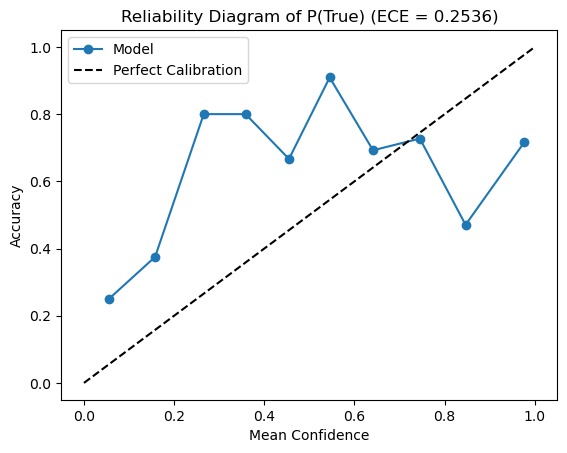

0.675


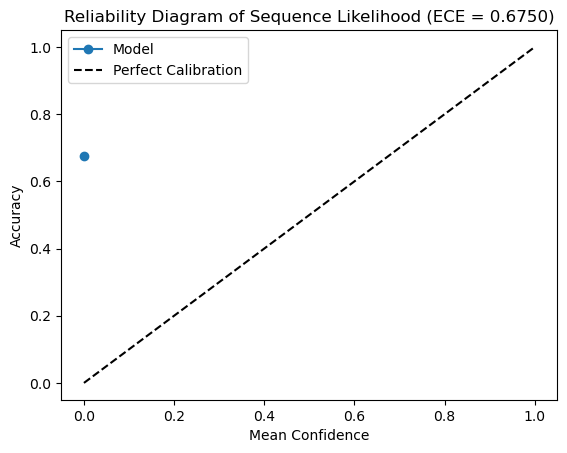

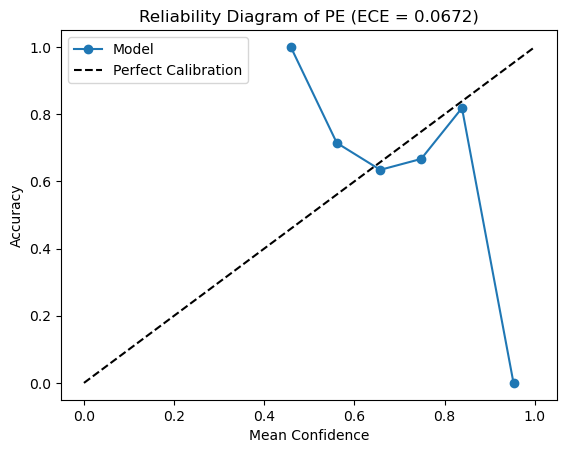

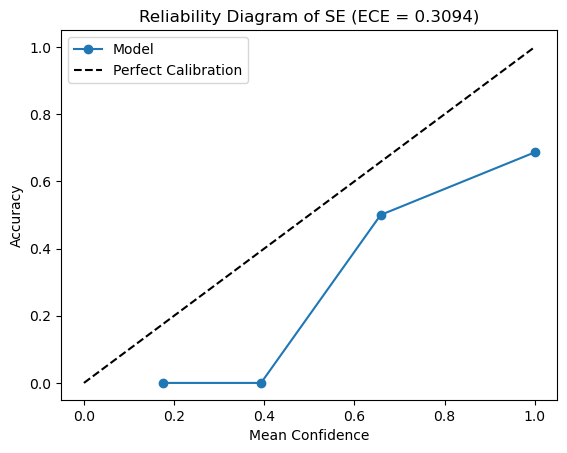

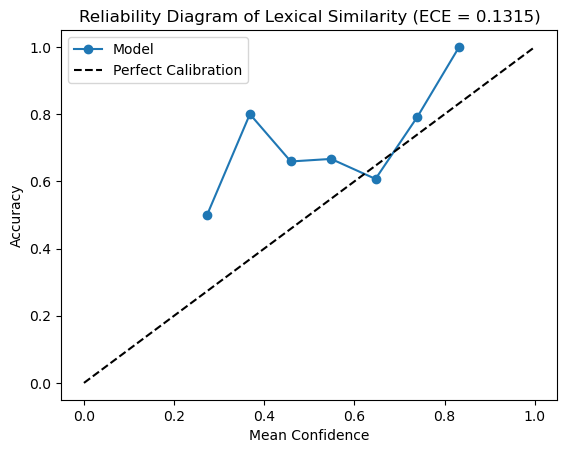

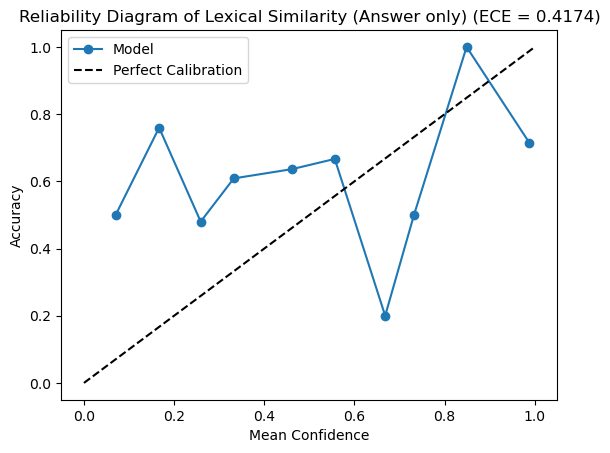

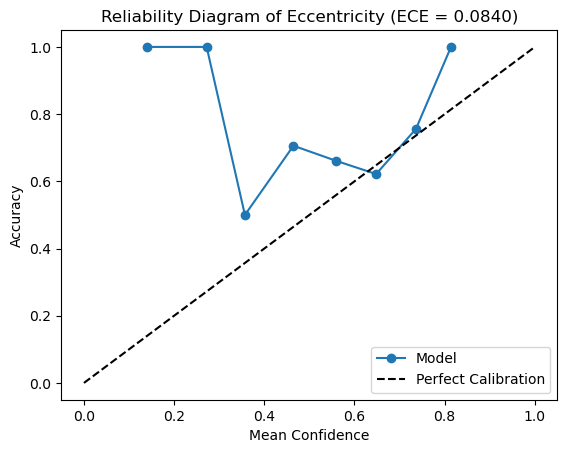

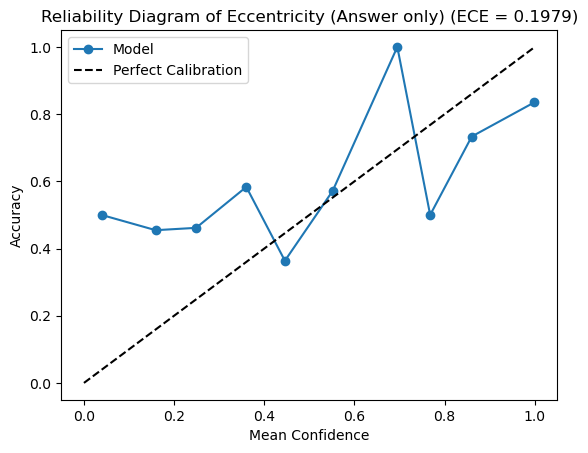

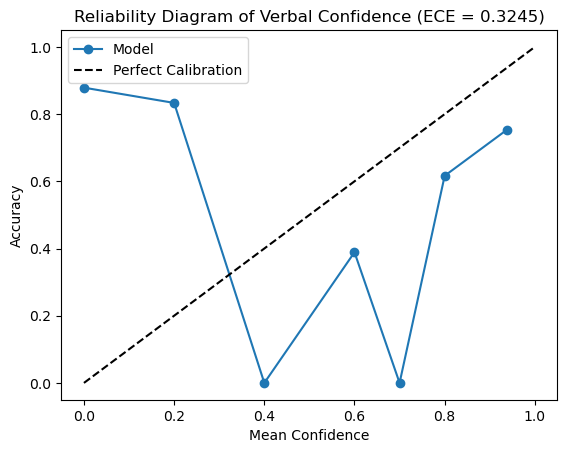

In [25]:
logit_ece = reliability_diagram_2(p_true_title, p_true, accuracy)
print(compute_accuracy(accuracy))

sequence_likelihood_ece = reliability_diagram_2(sequence_likelihood_title, sequence_likelihood, accuracy)

pe_ece = reliability_diagram_2(pe_title, pe, accuracy)
se_ece = reliability_diagram_2(se_title, se, accuracy)
ls_ece = reliability_diagram_2(ls_title, ls, accuracy)
ls_ao_ece = reliability_diagram_2(ls_ao_title, ls_ao, accuracy)
ecc_ece = reliability_diagram_2(eccentricity_title, ecc, accuracy)
ecc_ao_ece = reliability_diagram_2(eccentricity_ao_title, ecc_ao, accuracy)
vc_ece = reliability_diagram_2(verbal_confidence_title, vc, accuracy)

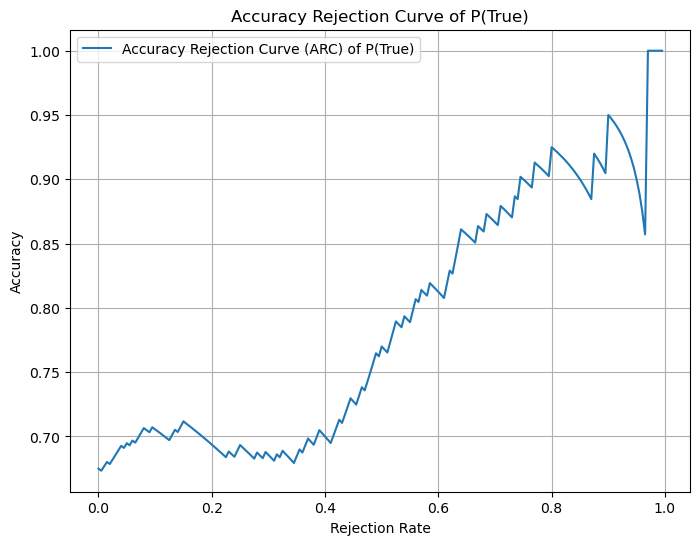

Area Under the Accuracy Rejection Curve (AUARC): 0.7839


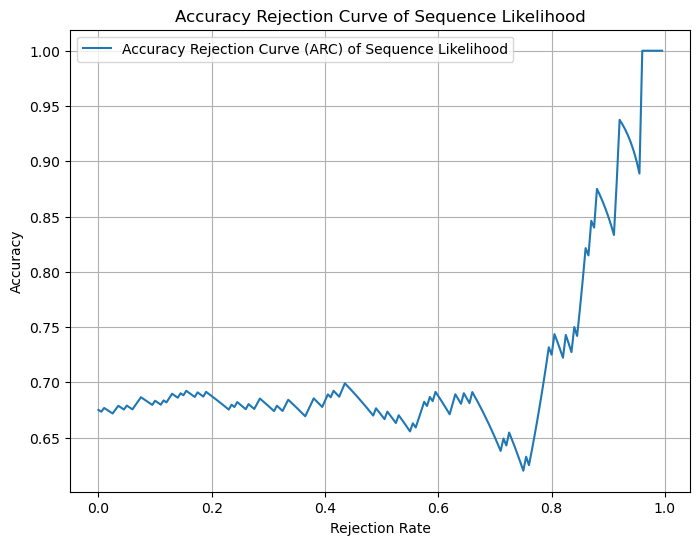

Area Under the Accuracy Rejection Curve (AUARC): 0.7093


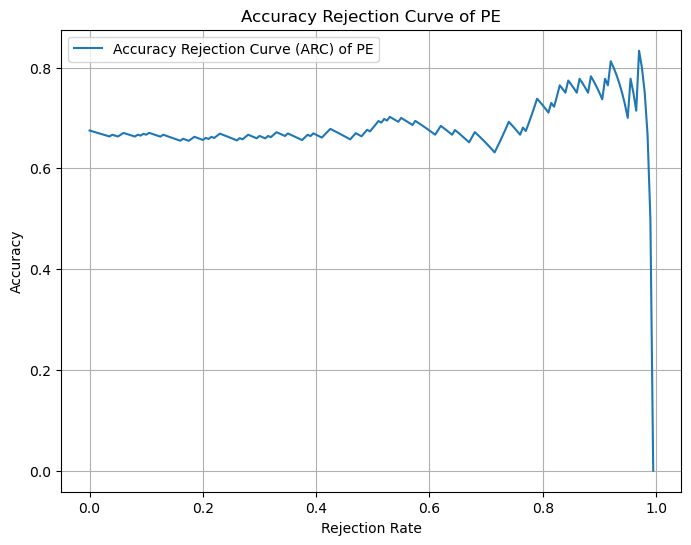

Area Under the Accuracy Rejection Curve (AUARC): 0.6804


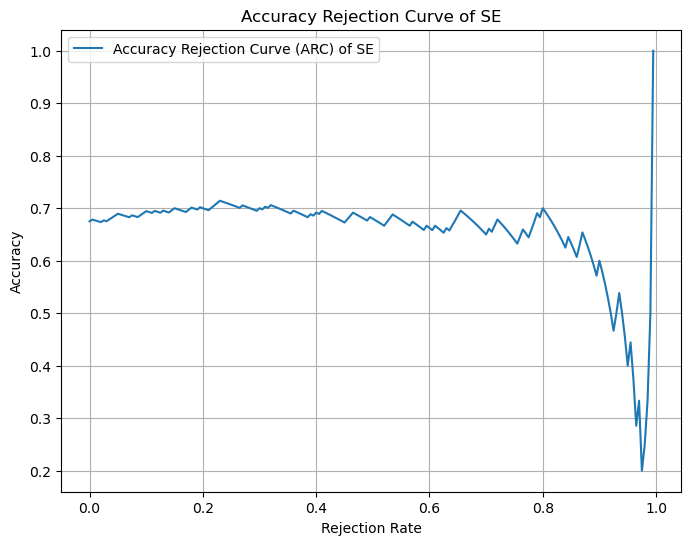

Area Under the Accuracy Rejection Curve (AUARC): 0.6529


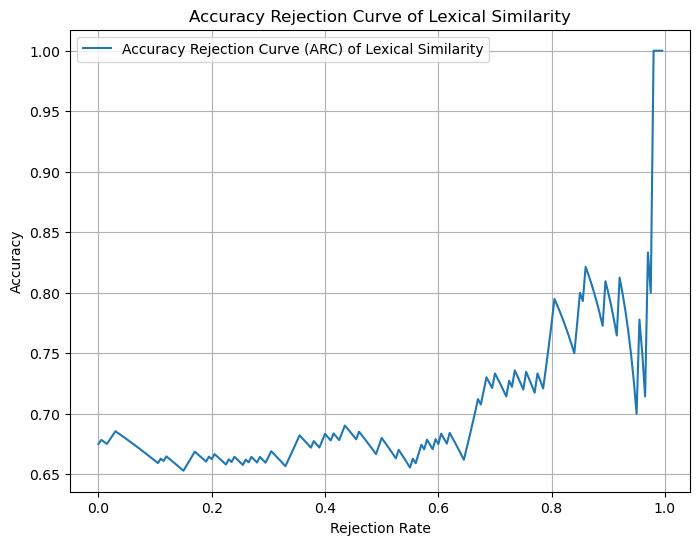

Area Under the Accuracy Rejection Curve (AUARC): 0.6999


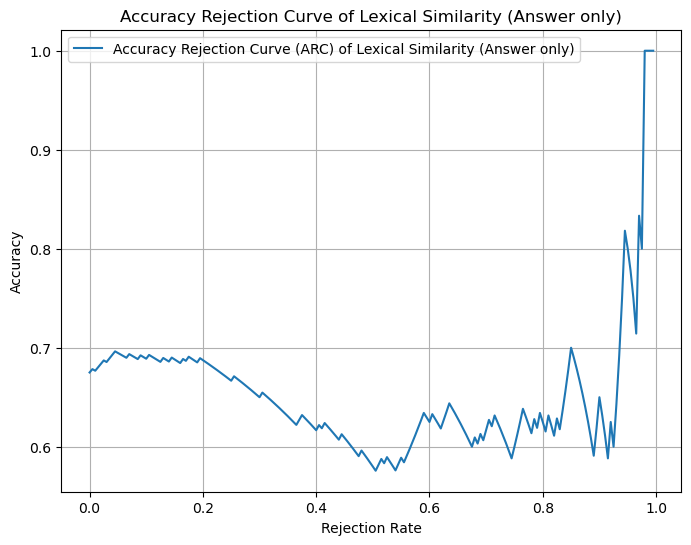

Area Under the Accuracy Rejection Curve (AUARC): 0.6485


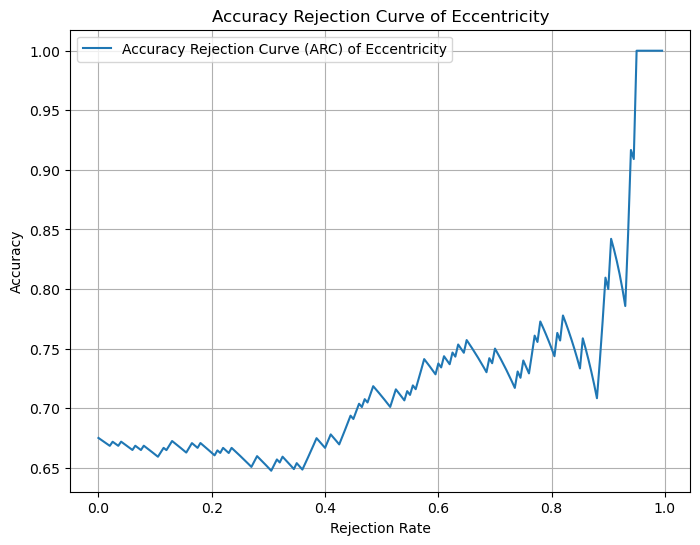

Area Under the Accuracy Rejection Curve (AUARC): 0.7177


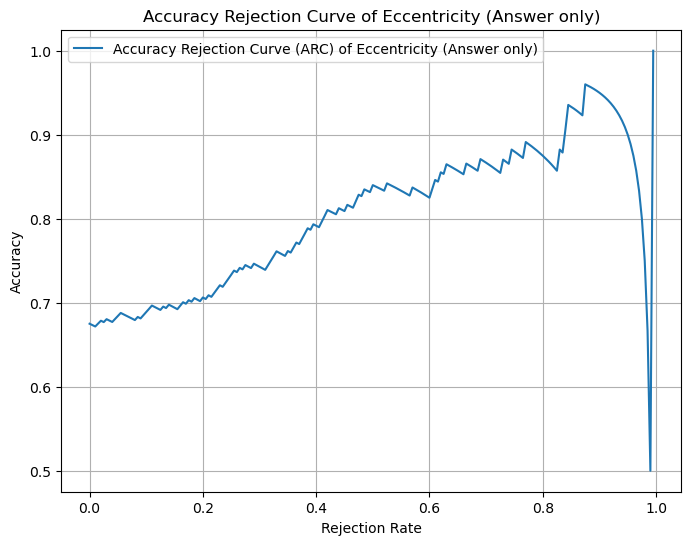

Area Under the Accuracy Rejection Curve (AUARC): 0.7985


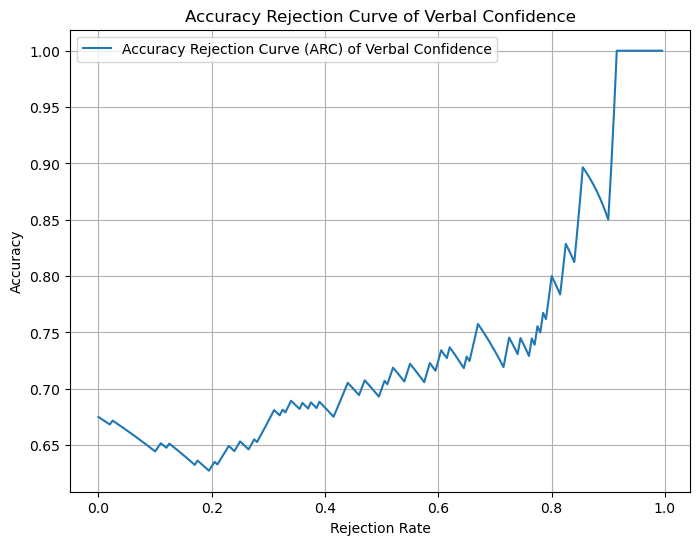

Area Under the Accuracy Rejection Curve (AUARC): 0.7305


0.730454030997699

In [24]:
plot_arc_and_calculate_auarc(p_true_title, p_true_p)
plot_arc_and_calculate_auarc(sequence_likelihood_title, sl_p)
plot_arc_and_calculate_auarc(pe_title, pe_p)
plot_arc_and_calculate_auarc(se_title, se_p)
plot_arc_and_calculate_auarc(ls_title, ls_p)
plot_arc_and_calculate_auarc(ls_ao_title, ls_ao_p)
plot_arc_and_calculate_auarc(eccentricity_title, ecc_p)
plot_arc_and_calculate_auarc(eccentricity_ao_title, ecc_ao_p)
plot_arc_and_calculate_auarc(verbal_confidence_title, vc_p)

## TruthfulQA

In [26]:
filename = 'Experiments/TRUTHFULQA_E1.csv' # GSM8K_E1.csv TRUTHFULQA_E1.csv
with open(filename, mode='r') as file:
    reader = csv.DictReader(file)
    data_list = [row for row in reader]

In [27]:
accuracy = []
p_true = []
p_true_p = []
sequence_likelihood = [] 
sl_p = []
pe = []
pe_p = []
se = []
se_p = []
ls = []
ls_p = []
ls_ao = []
ls_ao_p = []
ecc = []
ecc_p = []
ecc_ao = []
ecc_ao_p = []
vc = []
vc_p = []

for i, d in enumerate(data_list):
    # p_true
    accuracy.append(float(d['correct']))

    p_true.append(float(d['p_true']))
    p_true_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['p_true'])})
    
    sequence_likelihood.append(float(d['sequence_likelihoods']))
    sl_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['sequence_likelihoods'])})
    
    pe.append(1 - float(d['predictive_entropy']) / 10)
    pe_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['predictive_entropy']) / 10})
    
    se.append(1 - float(d['semantic_entropy']))
    se_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['semantic_entropy'])})
    
    ls.append(float(d['lexical_similarity']))
    ls_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['lexical_similarity'])})
    
    ls_ao.append(float(d['lexical_similarity_answer_only']))
    ls_ao_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['lexical_similarity_answer_only'])})
    
    ecc.append(1 - float(d['eccentricity']))
    ecc_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['eccentricity'])})
    
    ecc_ao.append(1 - float(d['eccentricity_answer_only']))
    ecc_ao_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['eccentricity_answer_only'])})
    
    vc.append(float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0)
    vc_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0})

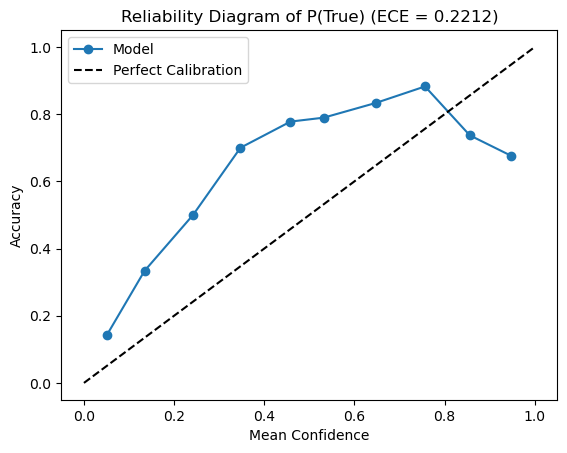

0.695


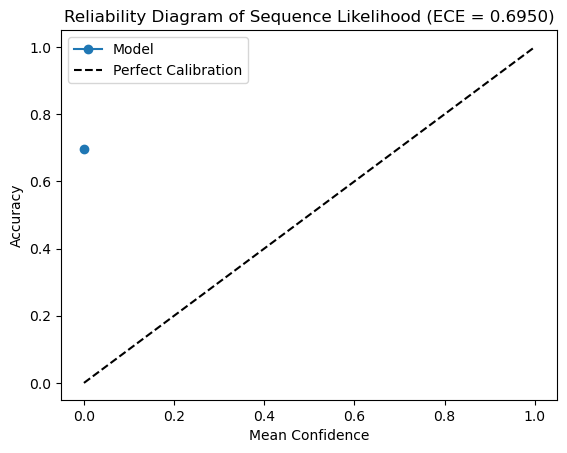

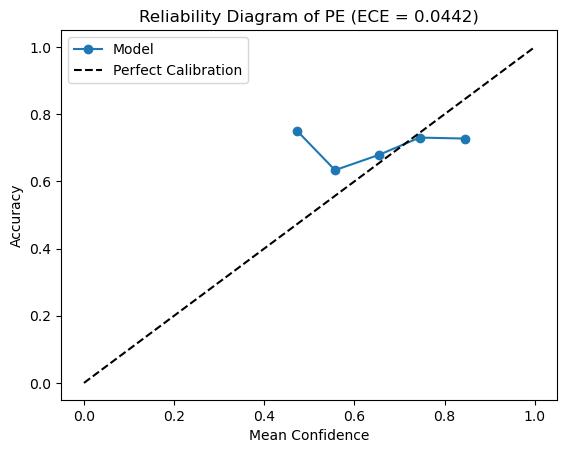

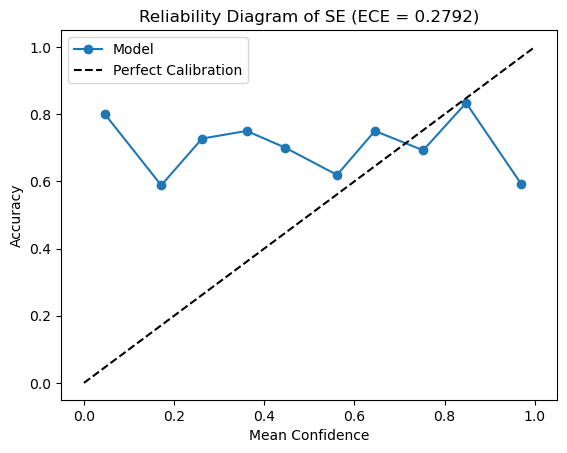

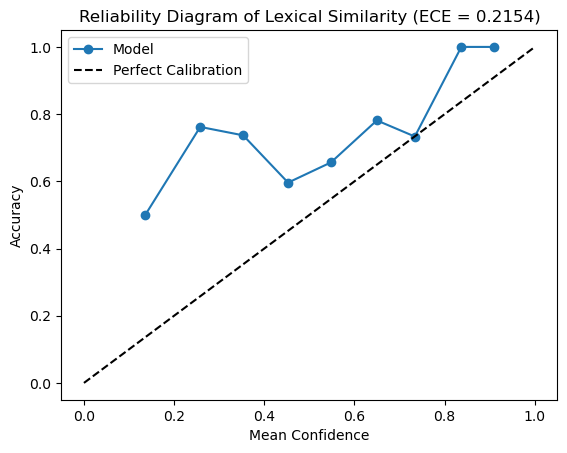

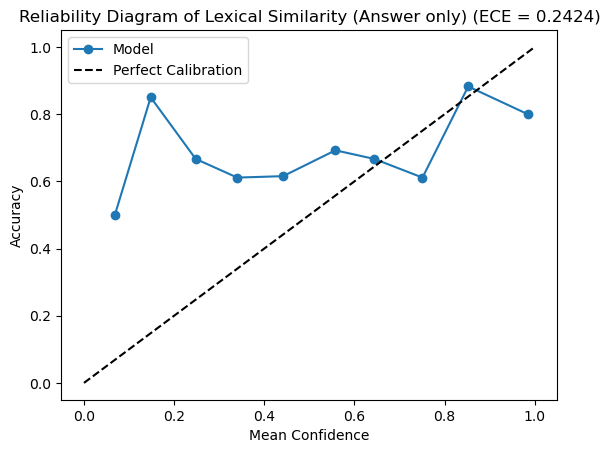

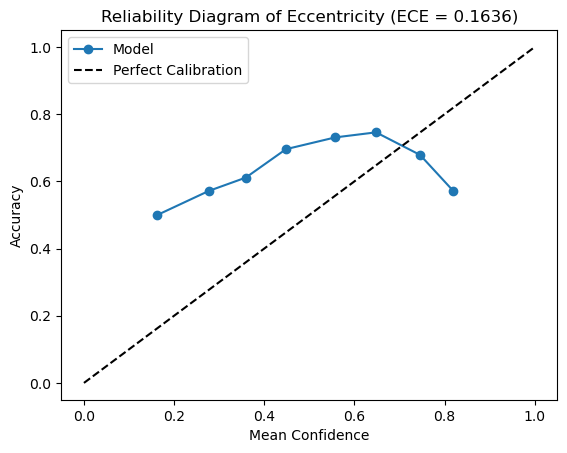

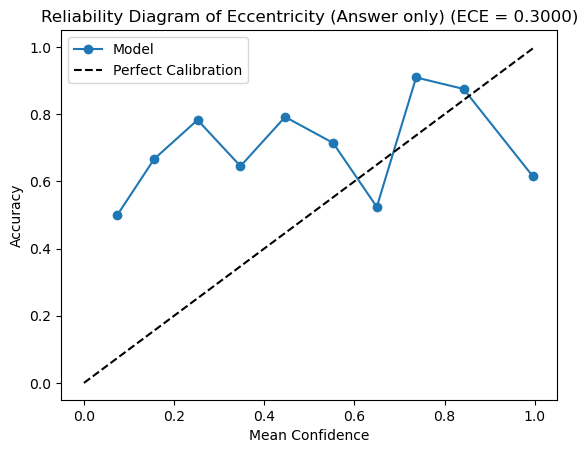

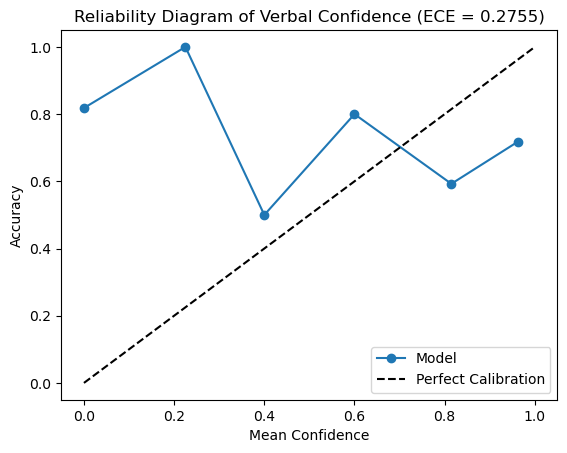

In [28]:
logit_ece = reliability_diagram_2(p_true_title, p_true, accuracy)
print(compute_accuracy(accuracy))

sequence_likelihood_ece = reliability_diagram_2(sequence_likelihood_title, sequence_likelihood, accuracy)

pe_ece = reliability_diagram_2(pe_title, pe, accuracy)
se_ece = reliability_diagram_2(se_title, se, accuracy)
ls_ece = reliability_diagram_2(ls_title, ls, accuracy)
ls_ao_ece = reliability_diagram_2(ls_ao_title, ls_ao, accuracy)
ecc_ece = reliability_diagram_2(eccentricity_title, ecc, accuracy)
ecc_ao_ece = reliability_diagram_2(eccentricity_ao_title, ecc_ao, accuracy)
vc_ece = reliability_diagram_2(verbal_confidence_title, vc, accuracy)

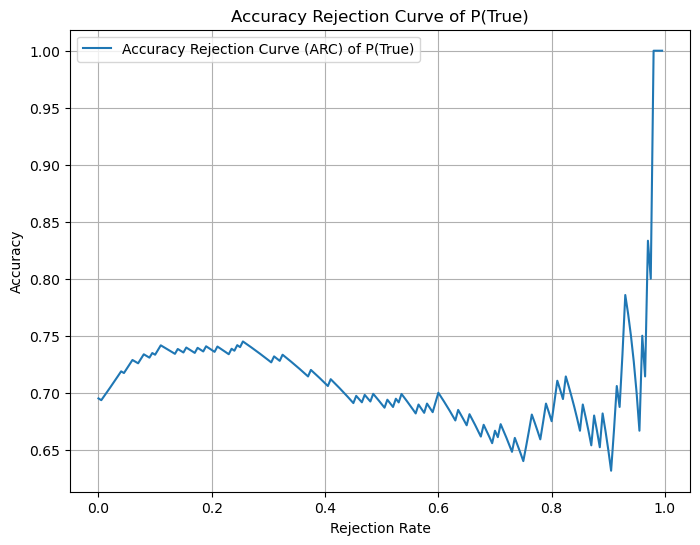

Area Under the Accuracy Rejection Curve (AUARC): 0.7065


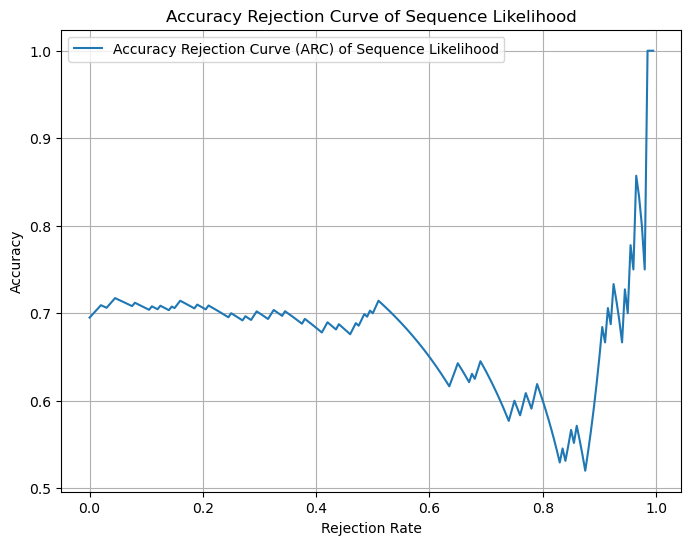

Area Under the Accuracy Rejection Curve (AUARC): 0.6709


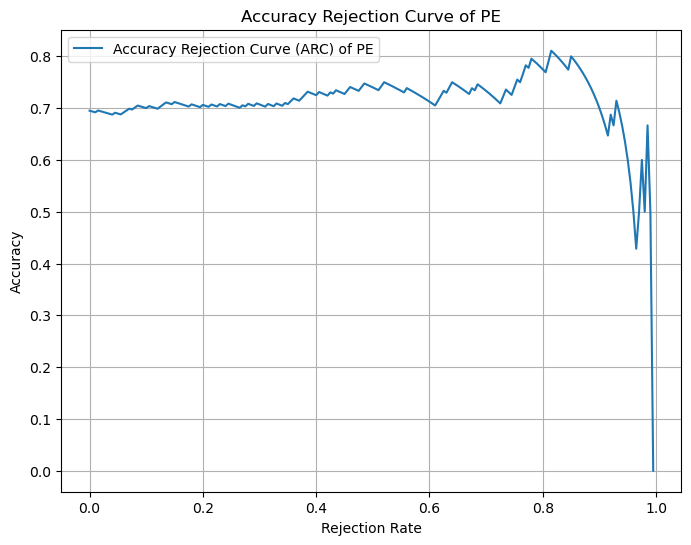

Area Under the Accuracy Rejection Curve (AUARC): 0.7106


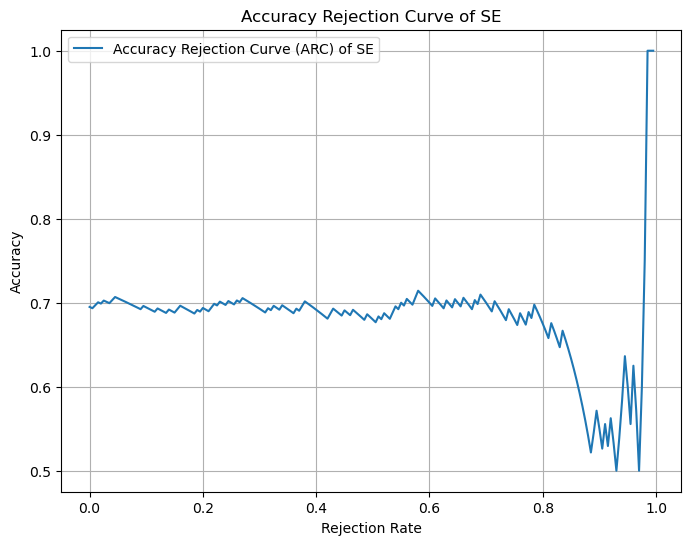

Area Under the Accuracy Rejection Curve (AUARC): 0.6764


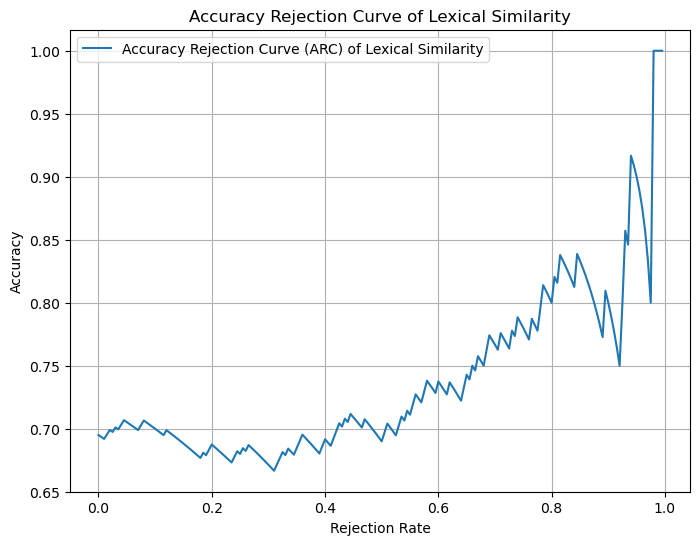

Area Under the Accuracy Rejection Curve (AUARC): 0.7332


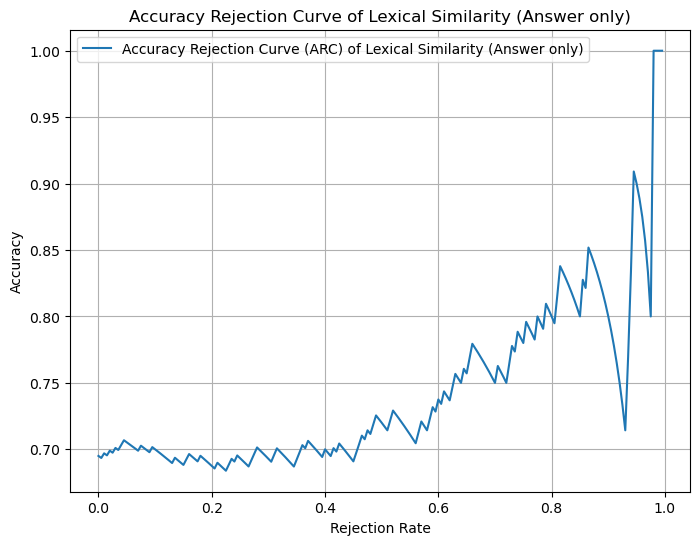

Area Under the Accuracy Rejection Curve (AUARC): 0.7371


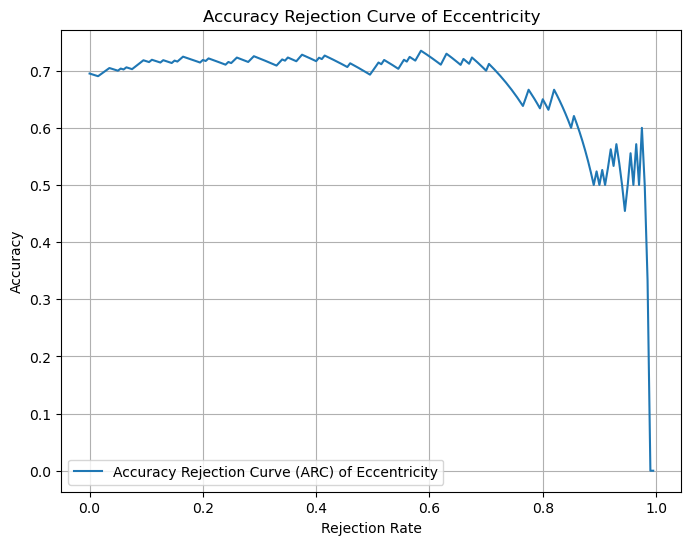

Area Under the Accuracy Rejection Curve (AUARC): 0.6723


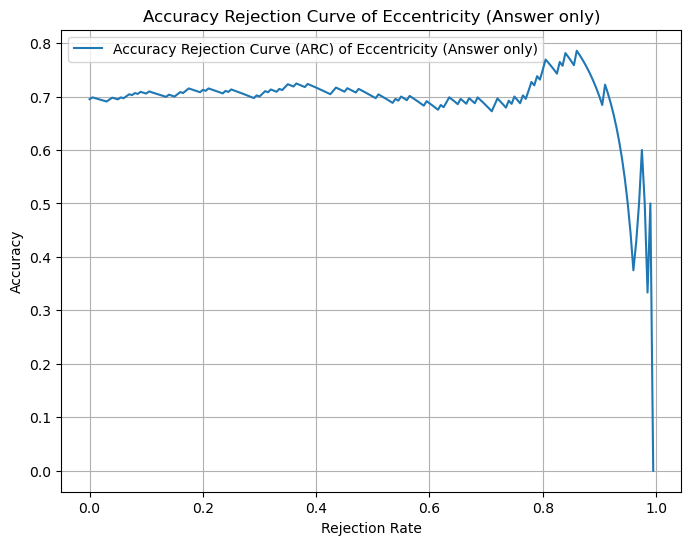

Area Under the Accuracy Rejection Curve (AUARC): 0.6898


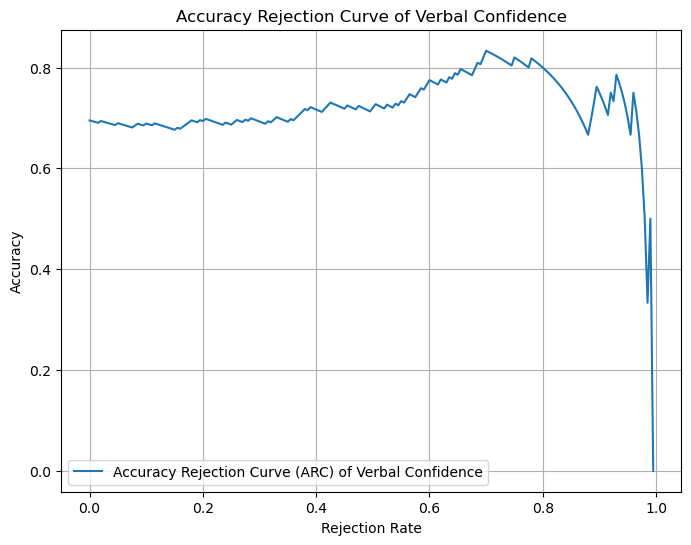

Area Under the Accuracy Rejection Curve (AUARC): 0.7192


0.719241480933467

In [29]:
plot_arc_and_calculate_auarc(p_true_title, p_true_p)
plot_arc_and_calculate_auarc(sequence_likelihood_title, sl_p)
plot_arc_and_calculate_auarc(pe_title, pe_p)
plot_arc_and_calculate_auarc(se_title, se_p)
plot_arc_and_calculate_auarc(ls_title, ls_p)
plot_arc_and_calculate_auarc(ls_ao_title, ls_ao_p)
plot_arc_and_calculate_auarc(eccentricity_title, ecc_p)
plot_arc_and_calculate_auarc(eccentricity_ao_title, ecc_ao_p)
plot_arc_and_calculate_auarc(verbal_confidence_title, vc_p)

## GSM8K

In [36]:
filename = 'Experiments/GSM8K_E1.csv'
with open(filename, mode='r') as file:
    reader = csv.DictReader(file)
    data_list = [row for row in reader]

In [38]:
accuracy = []
p_true = []
p_true_p = []
sequence_likelihood = [] 
sl_p = []
pe = []
pe_p = []
se = []
se_p = []
ls = []
ls_p = []
ls_ao = []
ls_ao_p = []
ecc = []
ecc_p = []
ecc_ao = []
ecc_ao_p = []
vc = []
vc_p = []

for i, d in enumerate(data_list):
    if (d['predicted_answer'] == ''):
        continue
    # p_true
    accuracy.append(float(d['correct']))

    p_true.append(float(d['p_true']))
    p_true_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['p_true'])})
    
    sequence_likelihood.append(float(d['sequence_likelihoods']))
    sl_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['sequence_likelihoods'])})
    
    pe.append(1 - float(d['predictive_entropy']) / 10)
    pe_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['predictive_entropy']) / 10})
    
    se.append(1 - float(d['semantic_entropy']))
    se_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['semantic_entropy'])})
    
    ls.append(float(d['lexical_similarity']))
    ls_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['lexical_similarity'])})
    
    ls_ao.append(float(d['lexical_similarity_answer_only']))
    ls_ao_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['lexical_similarity_answer_only'])})
    
    ecc.append(1 - float(d['eccentricity']))
    ecc_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['eccentricity'])})
    
    ecc_ao.append(1 - float(d['eccentricity_answer_only']))
    ecc_ao_p.append({'correct': float(d['correct']), 
                     'confidence': 1 - float(d['eccentricity_answer_only'])})
    
    vc.append(float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0)
    vc_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0})

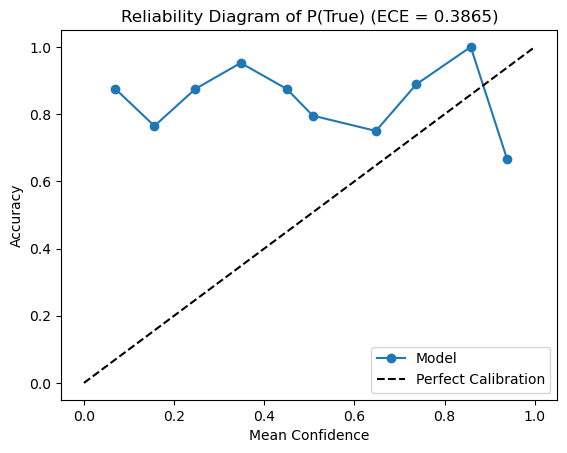

0.8341708542713567


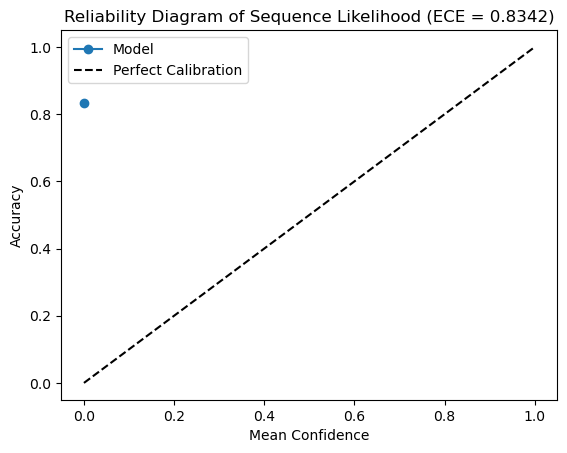

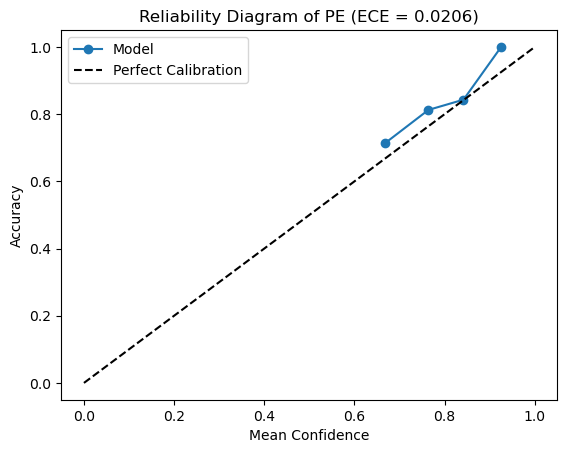

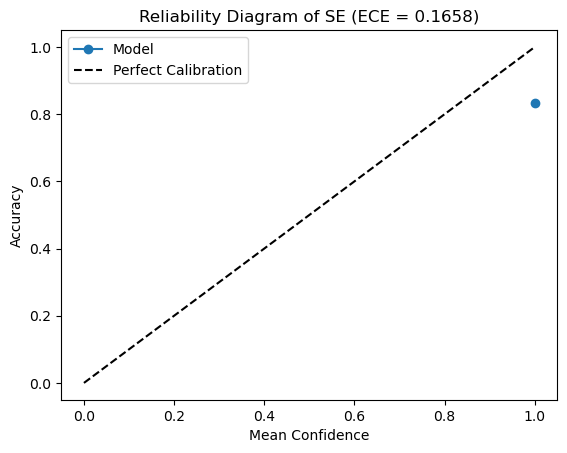

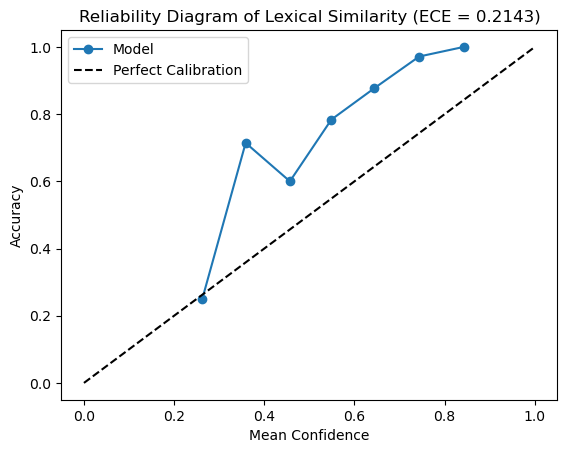

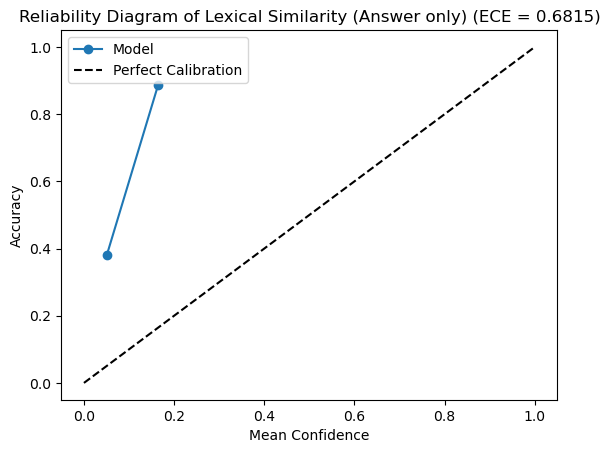

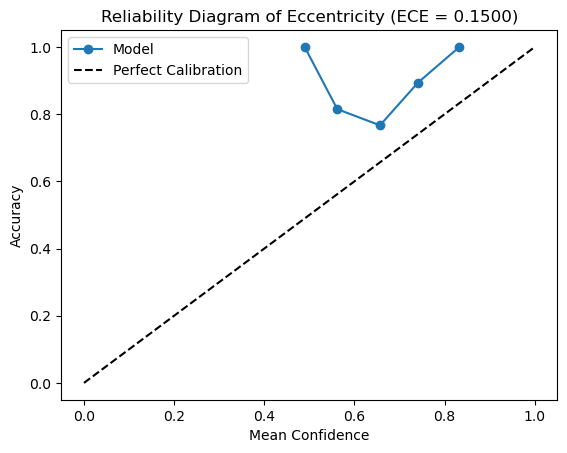

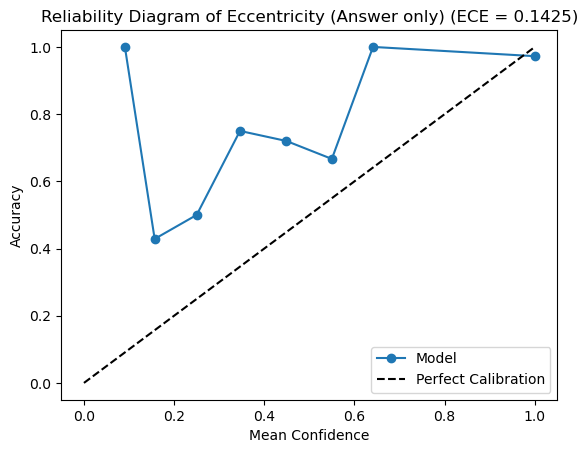

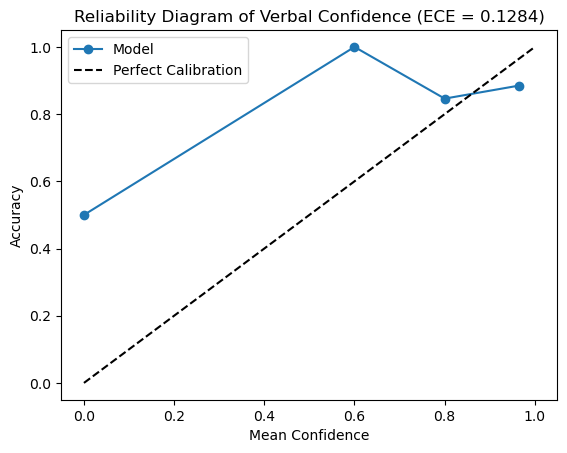

In [39]:
logit_ece = reliability_diagram_2(p_true_title, p_true, accuracy)
print(compute_accuracy(accuracy))

sequence_likelihood_ece = reliability_diagram_2(sequence_likelihood_title, sequence_likelihood, accuracy)

pe_ece = reliability_diagram_2(pe_title, pe, accuracy)
se_ece = reliability_diagram_2(se_title, se, accuracy)
ls_ece = reliability_diagram_2(ls_title, ls, accuracy)
ls_ao_ece = reliability_diagram_2(ls_ao_title, ls_ao, accuracy)
ecc_ece = reliability_diagram_2(eccentricity_title, ecc, accuracy)
ecc_ao_ece = reliability_diagram_2(eccentricity_ao_title, ecc_ao, accuracy)
vc_ece = reliability_diagram_2(verbal_confidence_title, vc, accuracy)

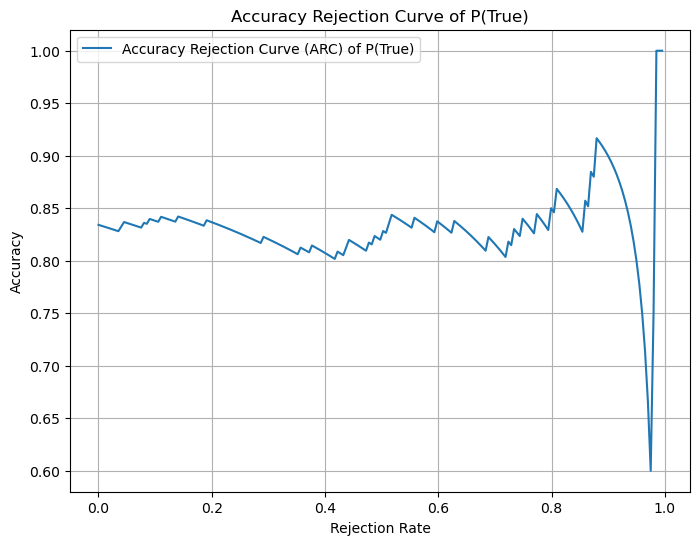

Area Under the Accuracy Rejection Curve (AUARC): 0.8266


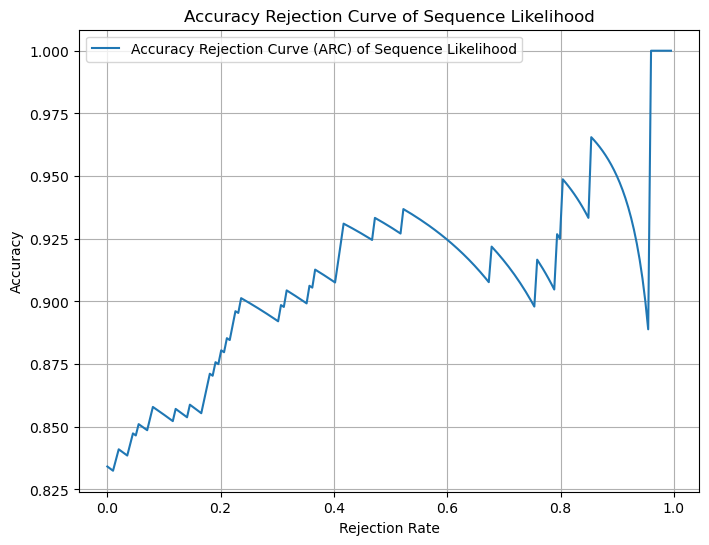

Area Under the Accuracy Rejection Curve (AUARC): 0.9047


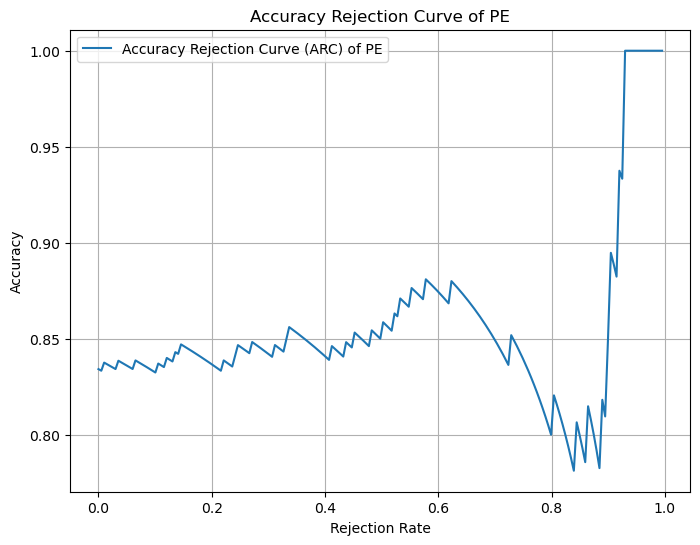

Area Under the Accuracy Rejection Curve (AUARC): 0.8508


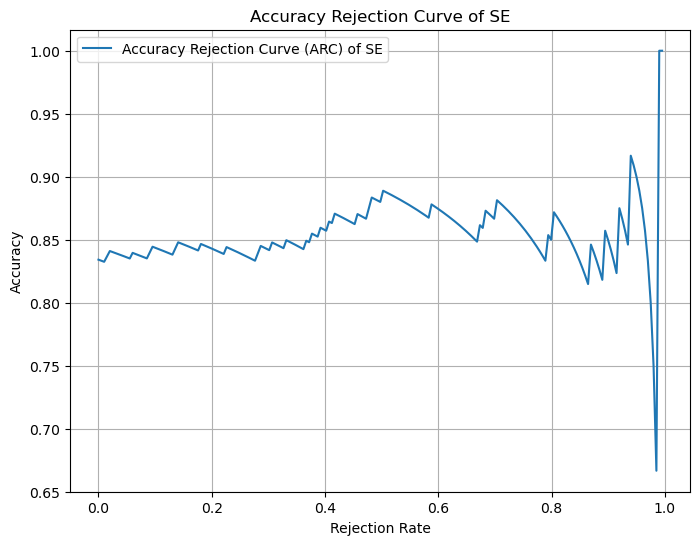

Area Under the Accuracy Rejection Curve (AUARC): 0.8497


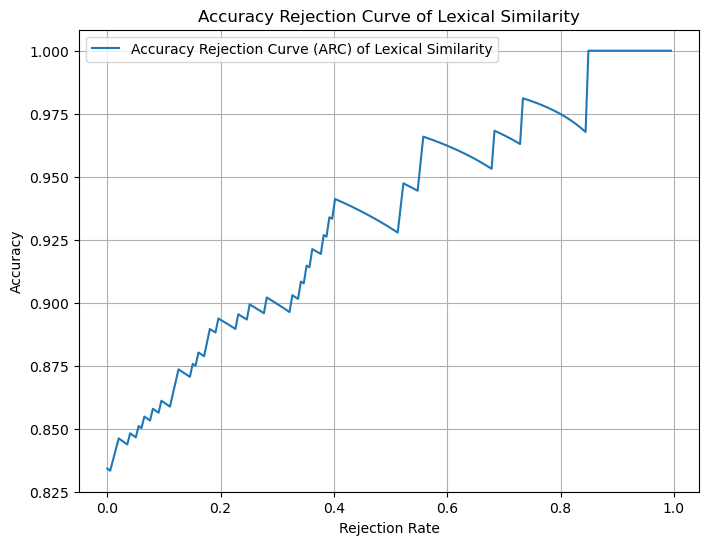

Area Under the Accuracy Rejection Curve (AUARC): 0.9291


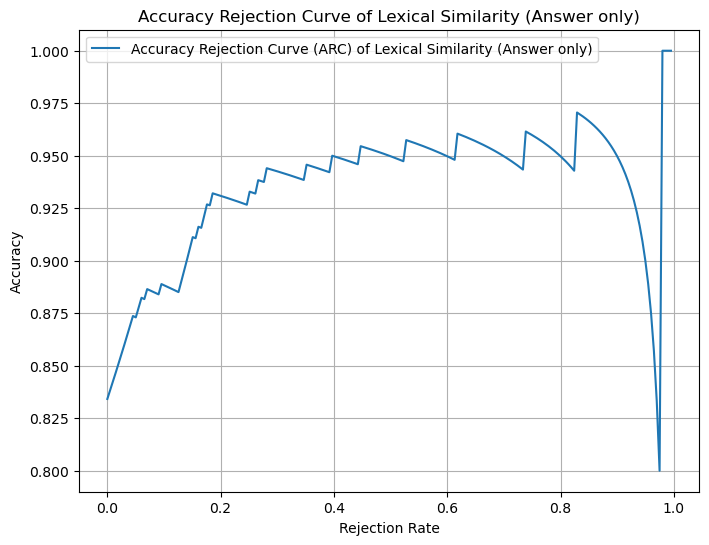

Area Under the Accuracy Rejection Curve (AUARC): 0.9297


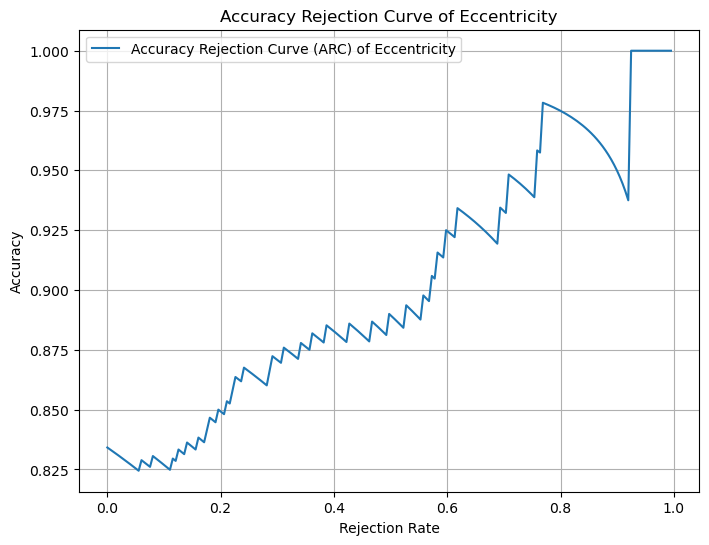

Area Under the Accuracy Rejection Curve (AUARC): 0.8969


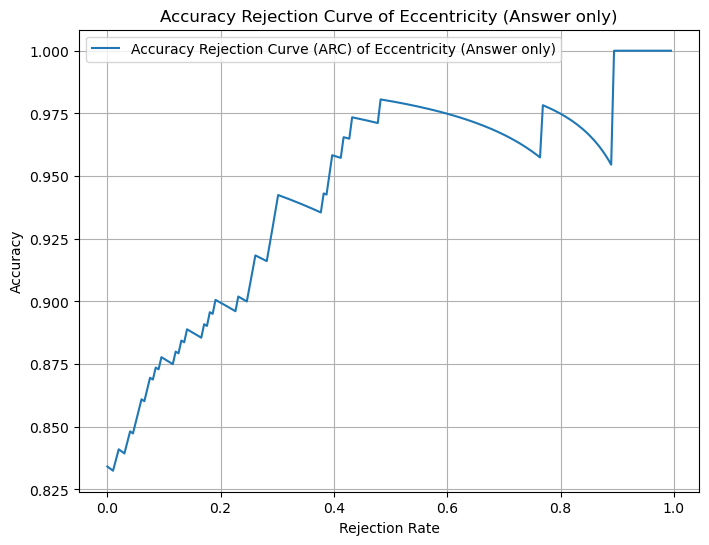

Area Under the Accuracy Rejection Curve (AUARC): 0.9396


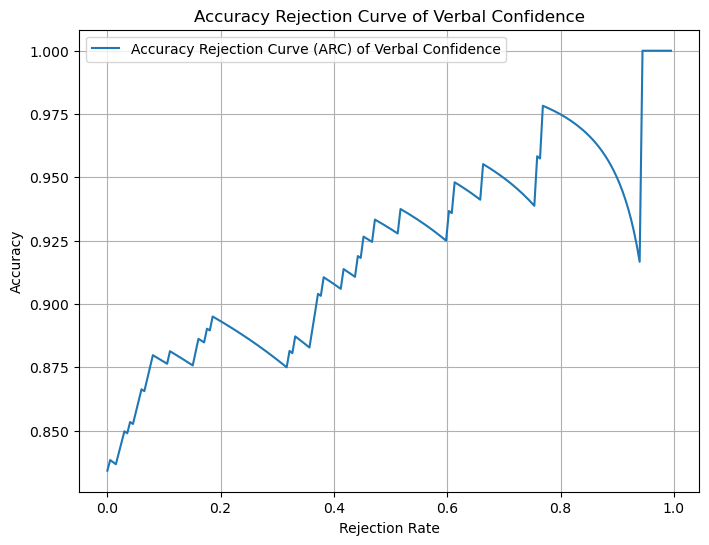

Area Under the Accuracy Rejection Curve (AUARC): 0.9161


0.9161138029648541

In [40]:
plot_arc_and_calculate_auarc(p_true_title, p_true_p)
plot_arc_and_calculate_auarc(sequence_likelihood_title, sl_p)
plot_arc_and_calculate_auarc(pe_title, pe_p)
plot_arc_and_calculate_auarc(se_title, se_p)
plot_arc_and_calculate_auarc(ls_title, ls_p)
plot_arc_and_calculate_auarc(ls_ao_title, ls_ao_p)
plot_arc_and_calculate_auarc(eccentricity_title, ecc_p)
plot_arc_and_calculate_auarc(eccentricity_ao_title, ecc_ao_p)
plot_arc_and_calculate_auarc(verbal_confidence_title, vc_p)

## Experiment 2

In [114]:
filename = 'Experiments/SQUAD_E2_2.csv'
with open(filename, mode='r') as file:
    reader = csv.DictReader(file)
    data_list = [row for row in reader]

In [46]:
title0 = "y_0"
title1 = "y_1'"
title2 = "y_2"
title3 = "y_3"
accuracy0 = []
accuracy1 = []
accuracy2 = []
accuracy3 = []
p_true0 = []
p_true1 = []
p_true2 = []
p_true3 = []
p_true0_p = []
p_true1_p = []
p_true2_p = []
p_true3_p = []

for i, d in enumerate(data_list):
    accuracy0.append(float(d['correct']))
    p_true0.append(float(d['p_true0']))
    p_true0_p.append({'correct': float(d['correct']), 
                     'confidence': float(d['p_true0'])})
    
    accuracy1.append(float(d['correct1']))
    p_true1.append(float(d['p_true1']))
    p_true1_p.append({'correct': float(d['correct1']), 
                     'confidence': float(d['p_true1'])})
    
    accuracy2.append(float(d['correct2']))
    p_true2.append(float(d['p_true2']))
    p_true2_p.append({'correct': float(d['correct2']), 
                     'confidence': float(d['p_true2'])})
    
    accuracy3.append(float(d['correct3']))
    p_true3.append(float(d['p_true3']))
    p_true3_p.append({'correct': float(d['correct3']), 
                     'confidence': float(d['p_true3'])})

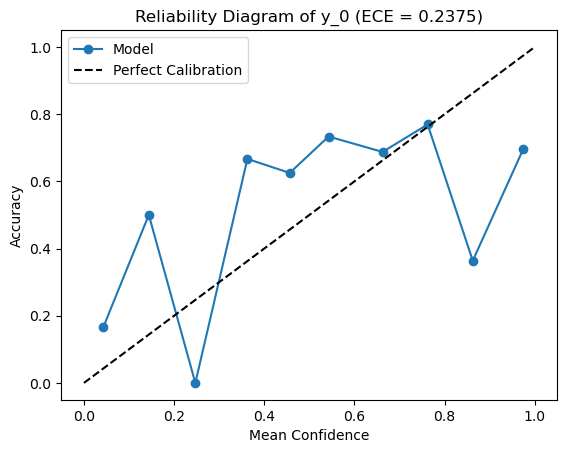

0.645


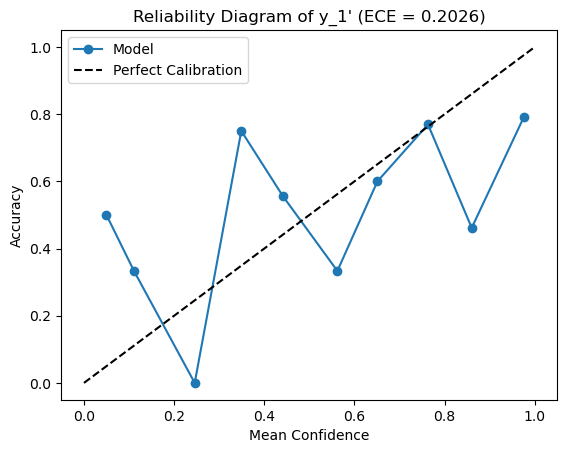

0.68


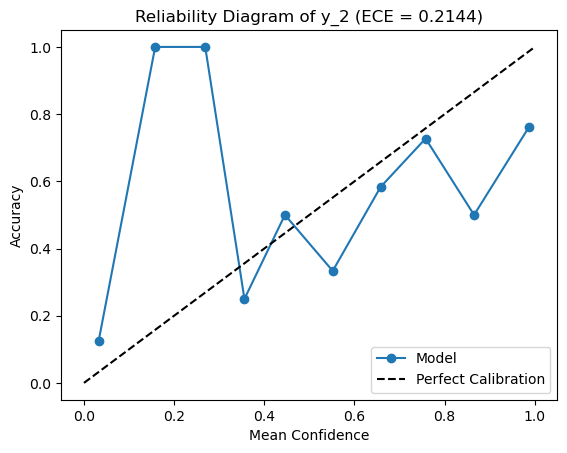

0.69


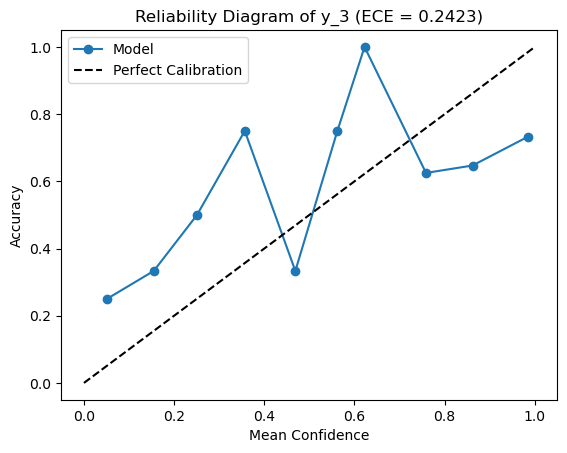

0.695


In [47]:
reliability_diagram_2(title0, p_true0, accuracy0)
print(compute_accuracy(accuracy0))

reliability_diagram_2(title1, p_true1, accuracy1)
print(compute_accuracy(accuracy1))

reliability_diagram_2(title2, p_true2, accuracy2)
print(compute_accuracy(accuracy2))

reliability_diagram_2(title3, p_true3, accuracy3)
print(compute_accuracy(accuracy3))

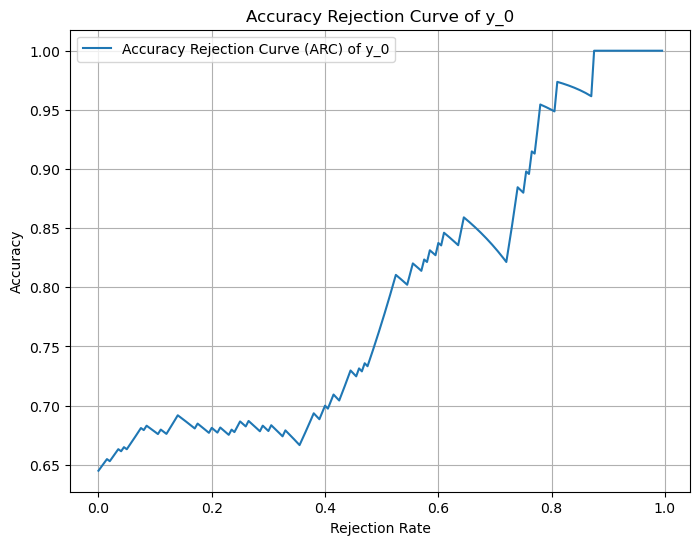

Area Under the Accuracy Rejection Curve (AUARC): 0.7906


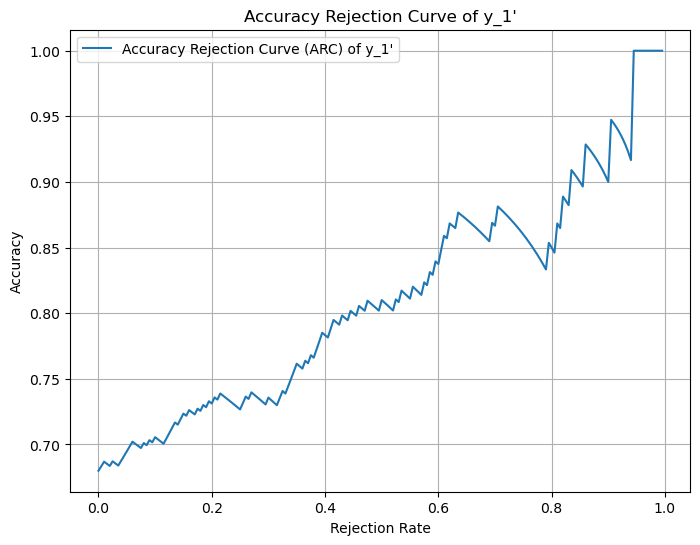

Area Under the Accuracy Rejection Curve (AUARC): 0.8059


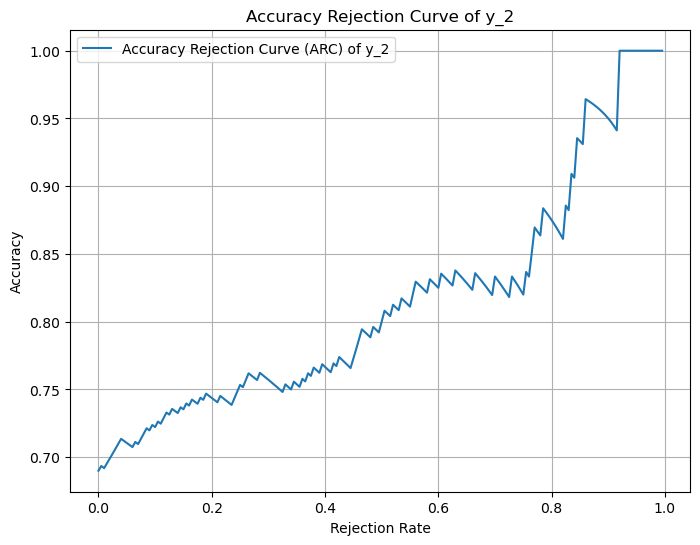

Area Under the Accuracy Rejection Curve (AUARC): 0.8085


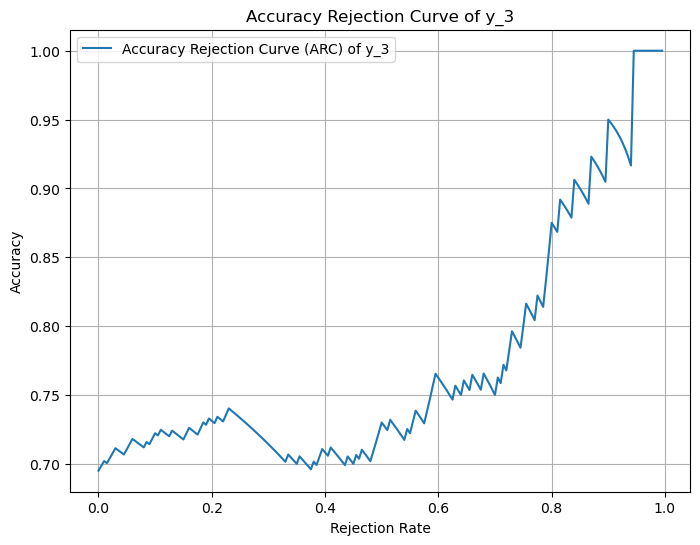

Area Under the Accuracy Rejection Curve (AUARC): 0.7685


0.7685091737806473

In [48]:
plot_arc_and_calculate_auarc(title0, p_true0_p)
plot_arc_and_calculate_auarc(title1, p_true1_p)
plot_arc_and_calculate_auarc(title2, p_true2_p)
plot_arc_and_calculate_auarc(title3, p_true3_p)

In [116]:
title0 = "y_0"
title1 = "y_1'"
title2 = "y_2"
title3 = "y_3"
p = []
for i, d in enumerate(data_list):
    p.append({
        "correct0": float(d['correct']),
        "correct1": float(d['correct1']),
        "correct2": float(d['correct2']),
        "correct3": float(d['correct3']),
        "p_true0": float(d['p_true0']),
        "p_true1": float(d['p_true1']),
        "p_true2": float(d['p_true2']),
        "p_true3": float(d['p_true3'])
    })

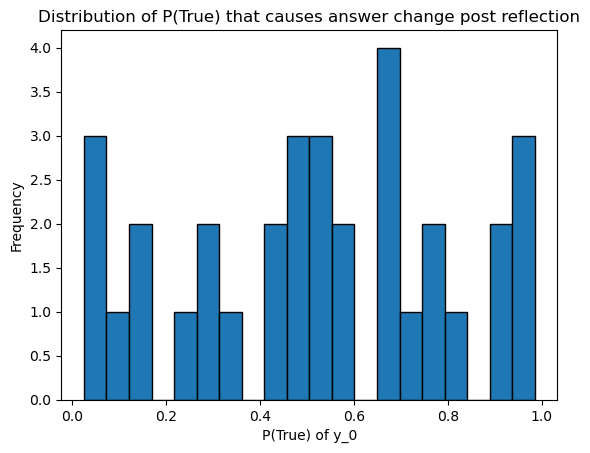

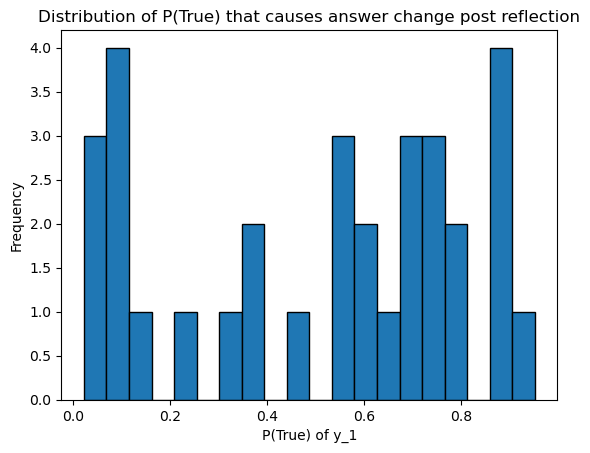

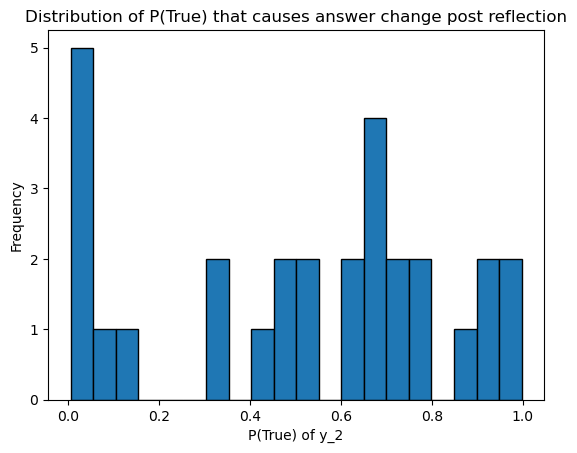

In [128]:
plt.hist(list(map(lambda x: x['p_true0'], [item for item in p if item['correct0'] != item['correct1']])), bins=20, edgecolor='black')
plt.title('Distribution of P(True) that causes answer change post reflection')
plt.xlabel('P(True) of y_0')
plt.ylabel('Frequency')
plt.show()

plt.hist(list(map(lambda x: x['p_true1'], [item for item in p if item['correct1'] != item['correct2']])), bins=20, edgecolor='black')
plt.title('Distribution of P(True) that causes answer change post reflection')
plt.xlabel('P(True) of y_1')
plt.ylabel('Frequency')
plt.show()


plt.hist(list(map(lambda x: x['p_true2'], [item for item in p if item['correct2'] != item['correct3']])), bins=20, edgecolor='black')
plt.title('Distribution of P(True) that causes answer change post reflection')
plt.xlabel('P(True) of y_2')
plt.ylabel('Frequency')
plt.show()

In [122]:
def draw_heatmap(title, ls):
    df = pd.DataFrame(ls)
    corr = df.corr(method='spearman')
    sns.heatmap(corr, annot=True, cmap="crest")
    plt.title(f"Correlation Matrix Heatmap ({title})")
    plt.show()

# P(True) and improvement in accuracy, hopefully it's correlated
print(compute_pointbiserial(list(map(lambda x: x['p_true0'], p)), list(map(lambda x: x['correct1'] - x['correct0'], p))))
print(compute_pointbiserial(list(map(lambda x: x['p_true1'], p)), list(map(lambda x: x['correct2'] - x['correct1'], p))))
print(compute_pointbiserial(list(map(lambda x: x['p_true2'], p)), list(map(lambda x: x['correct3'] - x['correct2'], p))))

Point Biserial Correlation: -0.15817608508353506
p-value: 0.025284497583372378
(-0.15817608508353506, 0.025284497583372378)
Point Biserial Correlation: -0.005752098763008036
p-value: 0.9355709925138496
(-0.005752098763008036, 0.9355709925138496)
Point Biserial Correlation: -0.19645661136092976
p-value: 0.00530142216945146
(-0.19645661136092976, 0.00530142216945146)


## Mutual Information

In [49]:
p_true_title = "P(True)"
sequence_likelihood_title = "Sequence Likelihood"
pe_title = "PE"
se_title = "SE"
ls_title = "Lexical Similarity"
ls_ao_title = "Lexical Similarity (Answer only)"
eccentricity_title = "Eccentricity"
eccentricity_ao_title = "Eccentricity (Answer only)"
verbal_confidence_title = "Verbal Confidence"

In [50]:
data_list = []
filename = 'Experiments/SQUAD_E1.csv'
with open(filename, mode='r') as file:
    reader = csv.DictReader(file)
    data_list = [row for row in reader]

data_list_nc = []
filename_nc = 'Experiments/SQUAD_NC_E1.csv'
with open(filename_nc, mode='r') as file_nc:
    reader = csv.DictReader(file_nc)
    data_list_nc = [row for row in reader]

In [ ]:
print(data_list[0])
print(data_list_nc[0])

In [73]:
"""
I = U(nc) - U(c)
I = 1 - P(True)_nc - (1 - P(True)_c)
I = P(True)_c - P(True)_nc
"""

accuracy = []
accuracy_nc = []

p_true = []
p_true_nc = []
p_true_p = []
p_true_p_nc = []

sequence_likelihood = [] 
sequence_likelihood_nc = []
sl_p = []
sl_p_nc = []

pe = []
pe_nc = []
pe_p = []
pe_p_nc = []

se = []
se_nc = []
se_p = []
se_p_nc = []

ls = []
ls_nc = []
ls_p = []
ls_p_nc = []

ls_ao = []
ls_ao_nc = []
ls_ao_p = []
ls_ao_p_nc = []

ecc = []
ecc_nc = []
ecc_p = []
ecc_p_nc = []

ecc_ao = []
ecc_ao_nc = []
ecc_ao_p = []
ecc_ap_p_nc = []

vc = []
vc_nc = []
vc_p = []
vc_p_nc = []

for i, d in enumerate(data_list):
    d_nc = data_list_nc[i]
    
    accuracy.append(float(d['correct']))
    accuracy_nc.append(float(d_nc['correct']))

    p_true_p.append({'accuracy': float(d['correct']), 
                     'confidence': float(d['p_true']),
                     'accuracy_nc': float(d_nc['correct']),
                     'confidence_nc': float(d_nc['p_true'])})
    
    sl_p.append({'accuracy': float(d['correct']), 
                 'confidence': float(d['sequence_likelihoods']),
                 'accuracy_nc': float(d_nc['correct']),
                 'confidence_nc': float(d_nc['sequence_likelihoods'])})
    
    pe.append(float(d['predictive_entropy']) / 10)
    pe_p.append({'accuracy': float(d['correct']), 
                 'uncertainty': float(d['predictive_entropy']) / 10,
                 'accuracy_nc': float(d_nc['correct']),
                 'uncertainty_nc': float(d_nc['predictive_entropy']) / 10})
    
    se.append(float(d['semantic_entropy']))
    se_p.append({'accuracy': float(d['correct']), 
                 'uncertainty': float(d['semantic_entropy']),
                 'accuracy_nc': float(d_nc['correct']), 
                 'uncertainty_nc': float(d_nc['semantic_entropy'])})
    
    ls.append(float(d['lexical_similarity']))
    ls_p.append({'accuracy': float(d['correct']), 
                 'confidence': float(d['lexical_similarity']),
                 'accuracy_nc': float(d_nc['correct']),
                 'confidence_nc': float(d_nc['lexical_similarity'])})
    
    ls_ao.append(float(d['lexical_similarity_answer_only']))
    ls_ao_p.append({'accuracy': float(d['correct']), 
                    'confidence': float(d['lexical_similarity_answer_only']),
                    'accuracy_nc': float(d_nc['correct']),
                    'confidence_nc': float(d_nc['lexical_similarity_answer_only'])})
    
    ecc.append(float(d['eccentricity']))
    ecc_p.append({'accuracy': float(d['correct']),
                  'uncertainty': float(d['eccentricity']),
                  'accuracy_nc': float(d_nc['correct']),
                  'uncertainty_nc': float(d_nc['eccentricity'])})
    
    ecc_ao.append(float(d['eccentricity_answer_only']))
    ecc_ao_p.append({'accuracy': float(d['correct']), 
                     'uncertainty': float(d['eccentricity_answer_only']),
                     'accuracy_nc': float(d_nc['correct']),
                     'uncertainty_nc': float(d_nc['eccentricity_answer_only'])})
    
    vc.append(float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0)
    vc_p.append({'accuracy': float(d['correct']), 
                 'confidence': float(d['verbalised_confidence']) / 100 if d['verbalised_confidence'] != '' else 0,
                 'accuracy_nc': float(d_nc['correct']),
                 'confidence_nc': float(d_nc['verbalised_confidence']) / 100 if d_nc['verbalised_confidence'] != '' else 0})

In [61]:
print("context:", sum(accuracy) / len(accuracy))
print("no context:", sum(accuracy_nc) / len(accuracy))

context: 0.675
no context: 0.325


In [75]:
def compute_mutual_information(is_confidence, d):
    if (is_confidence):
        return d['confidence'] - d['confidence_nc']
    else:
        return d['uncertainty_nc'] - d['uncertainty']

confidences = [p_true_p, sl_p, ls_p, ls_ao_p, vc_p]
for ls in confidences:
    for i, _ in enumerate(ls):
        ls[i]['I(y;c|x)'] = compute_mutual_information(True, ls[i])
        ls[i]['accuracy change'] = ls[i]['accuracy'] - ls[i]['accuracy_nc']
        ls[i].pop('accuracy', None)
        ls[i].pop('accuracy_nc', None)

uncertainties = [pe_p, se_p, ecc_p, ecc_ao_p]
for ls in uncertainties:
    for i, _ in enumerate(ls):
        ls[i]['I(y;c|x)'] = compute_mutual_information(False, ls[i])
        ls[i]['accuracy change'] = ls[i]['accuracy'] - ls[i]['accuracy_nc']
        ls[i].pop('accuracy', None)
        ls[i].pop('accuracy_nc', None)

In [70]:
def draw_heatmap(title, ls):
    df = pd.DataFrame(ls)
    corr = df.corr(method='spearman')
    sns.heatmap(corr, annot=True, cmap="crest")
    plt.title(f"Correlation Matrix Heatmap ({title})")
    plt.show()

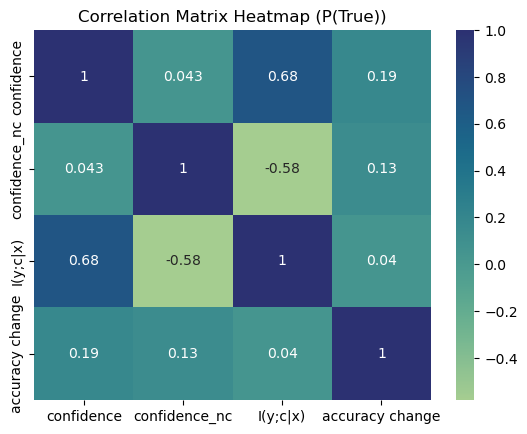

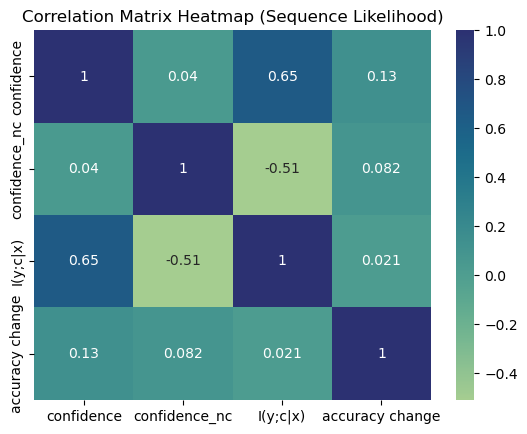

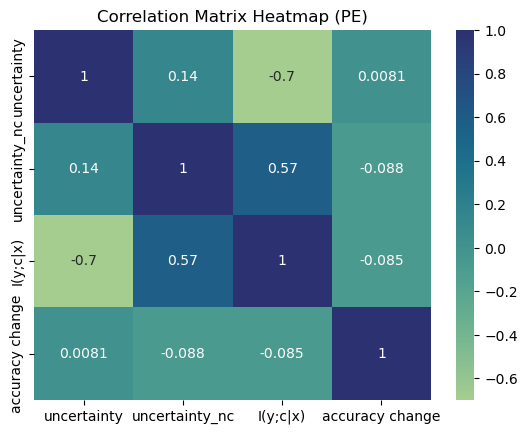

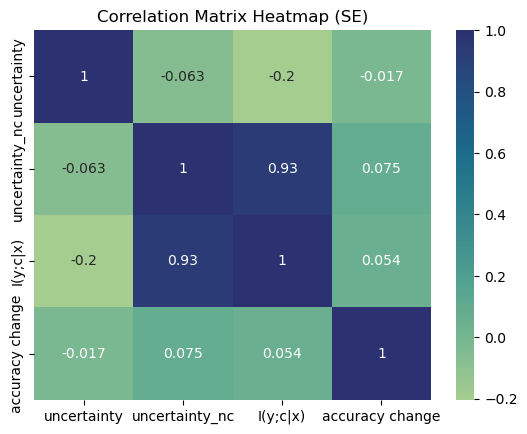

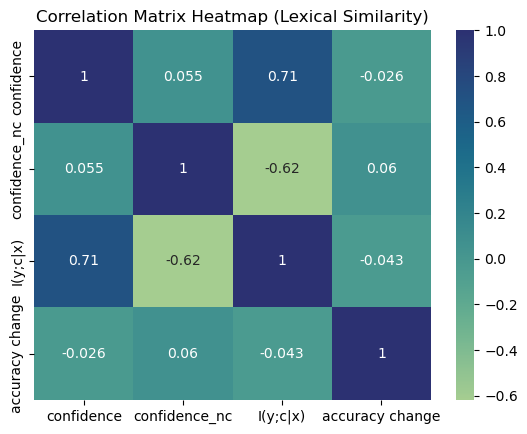

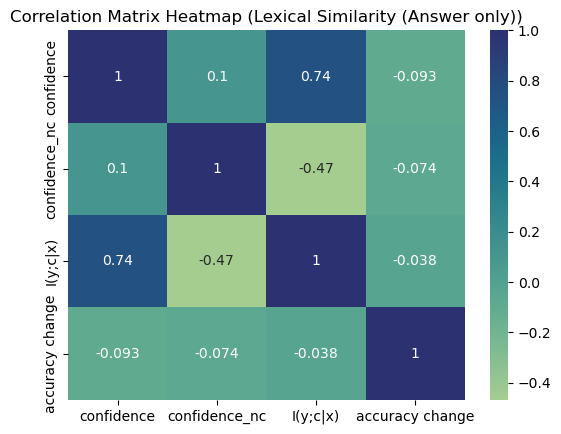

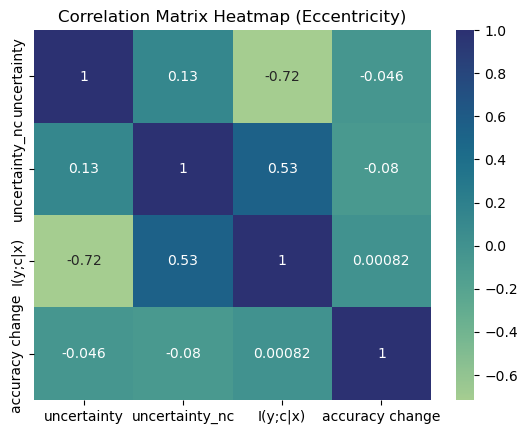

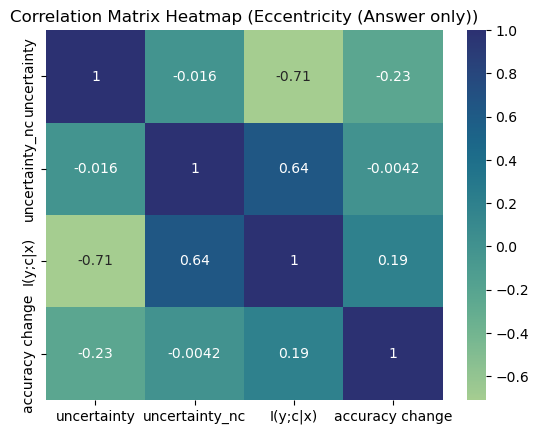

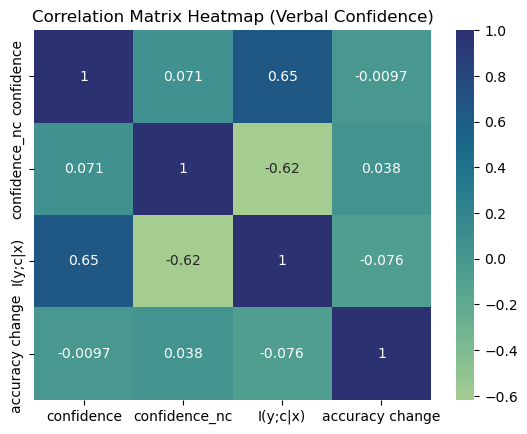

In [71]:
p_true_title = "P(True)"
sequence_likelihood_title = "Sequence Likelihood"
pe_title = "PE"
se_title = "SE"
ls_title = "Lexical Similarity"
ls_ao_title = "Lexical Similarity (Answer only)"
eccentricity_title = "Eccentricity"
eccentricity_ao_title = "Eccentricity (Answer only)"
verbal_confidence_title = "Verbal Confidence"

draw_heatmap(p_true_title, p_true_p)
draw_heatmap(sequence_likelihood_title, sl_p)
draw_heatmap(pe_title, pe_p)
draw_heatmap(se_title, se_p)
draw_heatmap(ls_title, ls_p)
draw_heatmap(ls_ao_title, ls_ao_p)
draw_heatmap(eccentricity_title, ecc_p)
draw_heatmap(eccentricity_ao_title, ecc_ao_p)
draw_heatmap(verbal_confidence_title, vc_p)

In [72]:
from scipy.stats import pointbiserialr
def compute_pointbiserial(uncertainty, accuracy):
    """
    Computes the point biserial correlation between uncertainty (continuous)
    and accuracy (binary: 0/1).
    """
    r, p_value = pointbiserialr(uncertainty, accuracy)
    print("Point Biserial Correlation:", r)
    print("p-value:", p_value)
    return r, p_value

In [77]:
confidences = [p_true_p, sl_p, ls_p, ls_ao_p, vc_p]
for ls in confidences:
    cr = compute_pointbiserial(list(map(lambda x: x['I(y;c|x)'], ls)), list(map(lambda x: x['accuracy change'], ls)))

uncertainties = [pe_p, se_p, ecc_p, ecc_ao_p]
for ls in uncertainties:
    cr = compute_pointbiserial(list(map(lambda x: x['I(y;c|x)'], ls)), list(map(lambda x: x['accuracy change'], ls)))

Point Biserial Correlation: 0.01023480385406586
p-value: 0.8856279996096885
Point Biserial Correlation: 0.06981054646034321
p-value: 0.32596145893102824
Point Biserial Correlation: -0.05452193984398305
p-value: 0.4432038714744204
Point Biserial Correlation: -0.048472468774607855
p-value: 0.4954866896225291
Point Biserial Correlation: -0.1453349953366353
p-value: 0.04003580137193803
Point Biserial Correlation: -0.08999788548689697
p-value: 0.20502730940176417
Point Biserial Correlation: 0.0926030116276033
p-value: 0.19216544828793783
Point Biserial Correlation: 0.018451339752556865
p-value: 0.795382303567406
Point Biserial Correlation: 0.2190322039004776
p-value: 0.0018326395239063715


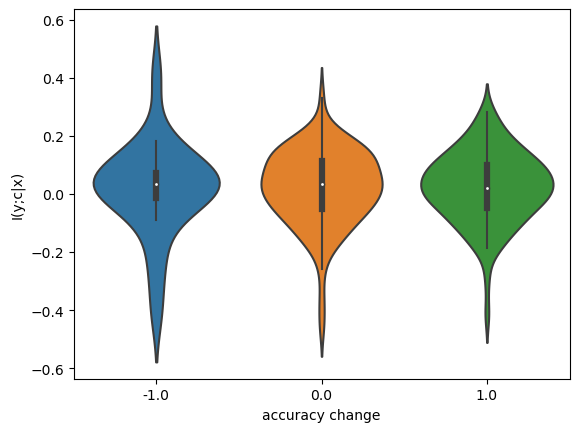

In [113]:
df = pd.DataFrame(ecc_p)

# Draw violin plot
sns.violinplot(x="accuracy change", y="I(y;c|x)", data=df)
plt.show()

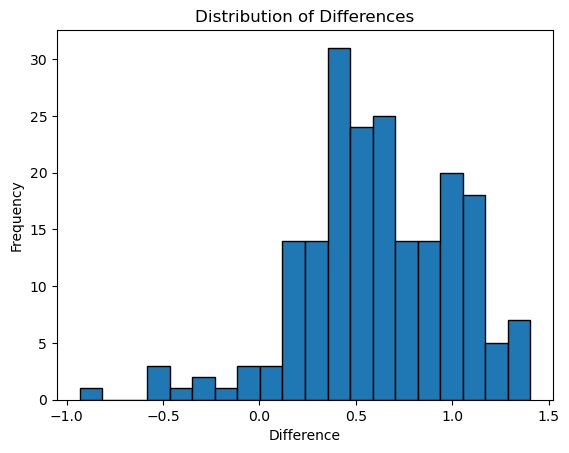

In [97]:
plt.hist(list(map(lambda x: x['I(y;c|x)'], se_p)), bins=20, edgecolor='black')
plt.title('Distribution of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

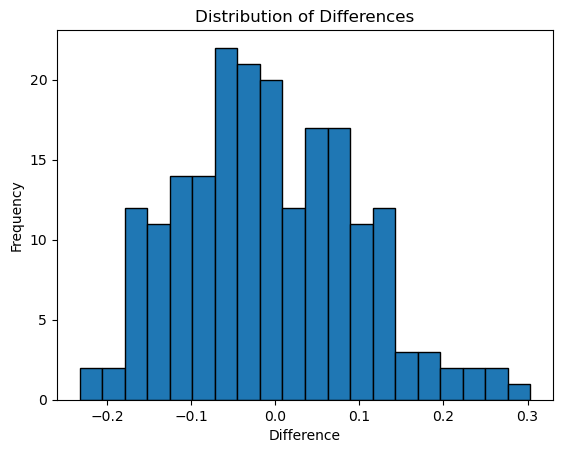

In [105]:
plt.hist(list(map(lambda x: x['I(y;c|x)'], pe_p)), bins=20, edgecolor='black')
plt.title('Distribution of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

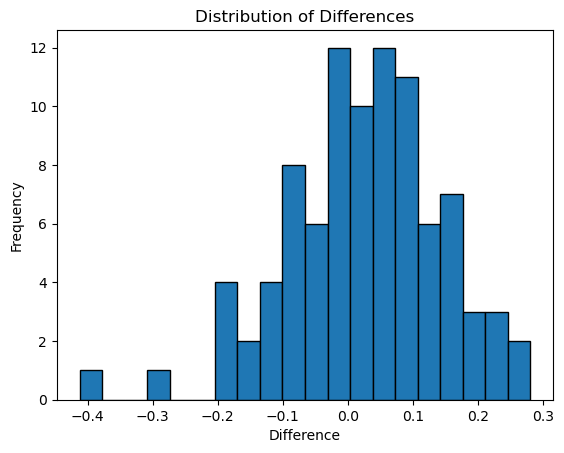

In [93]:
positive_delta = [d for d in ecc_p if d['accuracy change'] > 0]

plt.hist(list(map(lambda x: x['I(y;c|x)'], positive_delta)), bins=20, edgecolor='black')
plt.title('Distribution of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

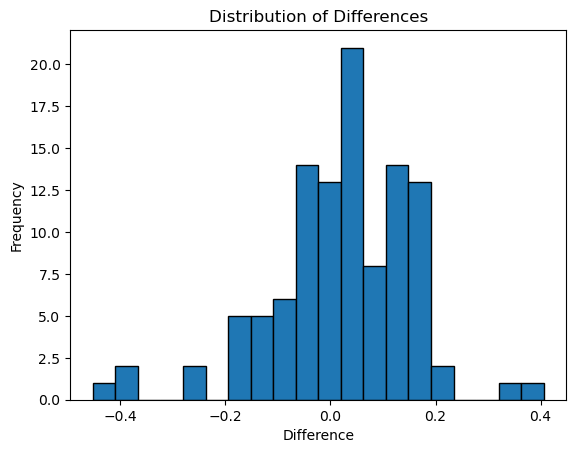

In [96]:
negative_delta = [d for d in ecc_p if d['accuracy change'] <= 0]

plt.hist(list(map(lambda x: x['I(y;c|x)'], negative_delta)), bins=20, edgecolor='black')
plt.title('Distribution of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [161]:
def accuracy_rejection_curve(name, probabilities, accuracies):
    probabilities = np.array(probabilities)
    accuracies = np.array(accuracies)

    sorted_indices = np.argsort(-probabilities)
    sorted_accuracies = np.array(accuracies)[sorted_indices]
    sorted_probabilities = np.array(probabilities)[sorted_indices]

    coverage = np.arange(1, len(probabilities) + 1) / len(probabilities)
    cumulative_accuracy = np.cumsum(sorted_accuracies) / coverage

    auarc = np.trapz(cumulative_accuracy, coverage)

    plt.figure()
    plt.plot(coverage, cumulative_accuracy, label=f'ARC (AUARC = {auarc:.4f})')
    plt.xlabel('Coverage')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy-Rejection Curve of {name}')
    plt.legend()
    plt.show()

    return auarc

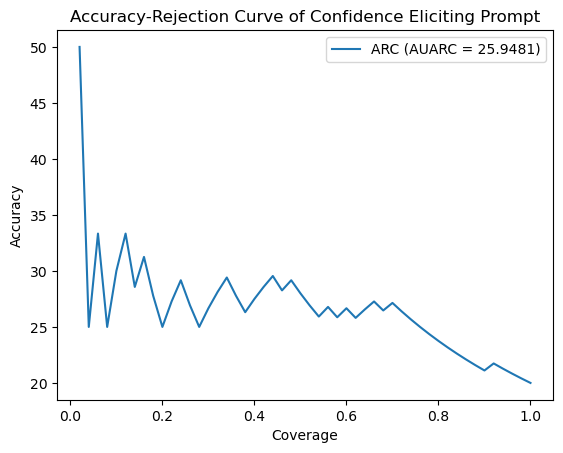

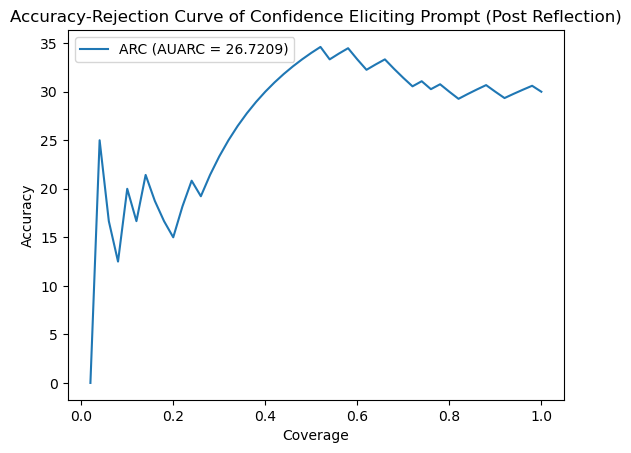

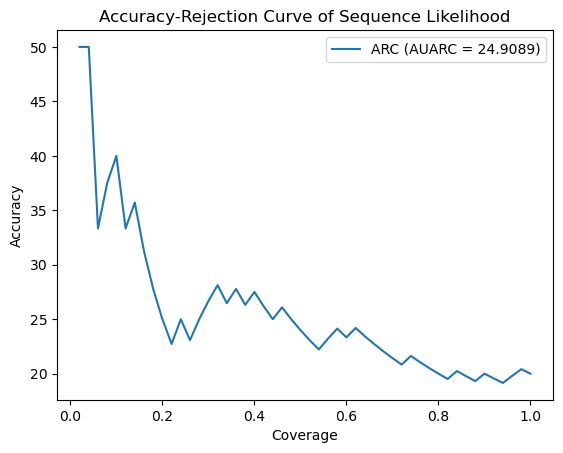

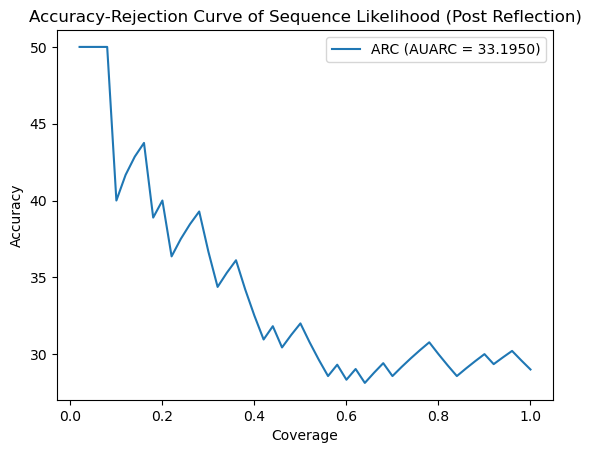

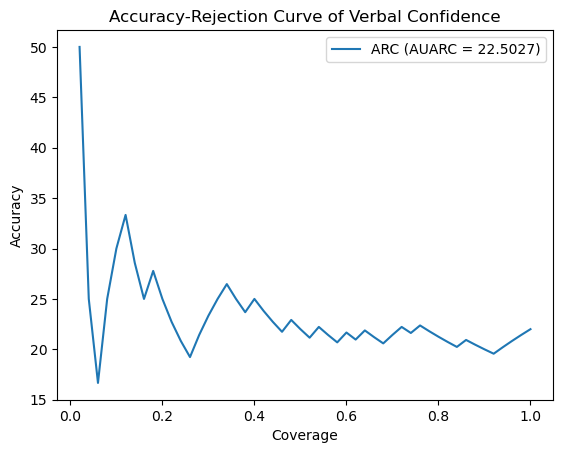

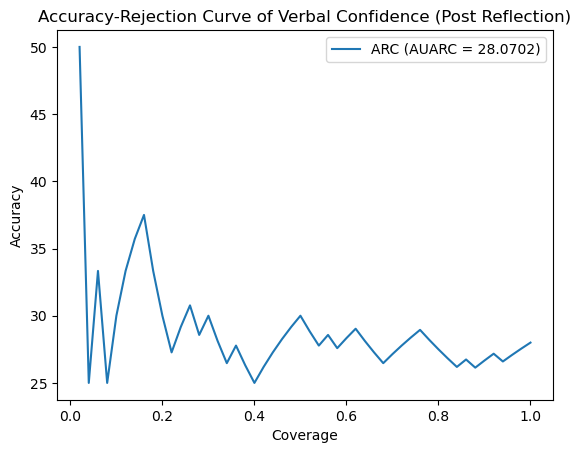

In [162]:
logit_auarc = accuracy_rejection_curve(logit_title, logit_confidence, accuracy)
logit_post_auarc = accuracy_rejection_curve(logit_post_title, logit_confidence_post, accuracy_post_reflection)

sequence_likelihood_auarc = accuracy_rejection_curve(sequence_likelihood_title, sequence_likelihood, accuracy)
sequence_likelihood_post_auarc = accuracy_rejection_curve(sequence_likelihood_post_title, sequence_likelihood_post, accuracy_post_reflection_seq)

verbal_confidence_auarc = accuracy_rejection_curve(verbal_confidence_title, verbal_confidence, accuracy_ver)
verbal_confidence_post_auarc = accuracy_rejection_curve(verbal_confidence_post_title, verbal_confidence_post, accuracy_post_reflection_ver)

In [ ]:
# # Example usage
# predictions = [
#     {'true label': 1, 'predicted label': 1, 'confidence': 0.85},
#     {'true label': 0, 'predicted label': 0, 'confidence': 0.90},
#     {'true label': 1, 'predicted label': 1, 'confidence': 0.78},
#     {'true label': 1, 'predicted label': 0, 'confidence': 0.60},
#     {'true label': 0, 'predicted label': 1, 'confidence': 0.50},
#     # Add more predictions as needed
# ]

# # Plot ARC and calculate AUARC
# auarc = plot_arc_and_calculate_auarc(predictions)

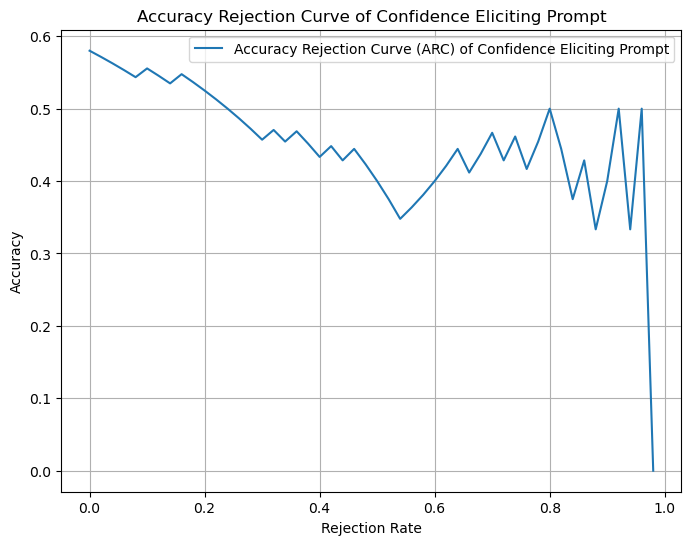

Area Under the Accuracy Rejection Curve (AUARC): 0.4448


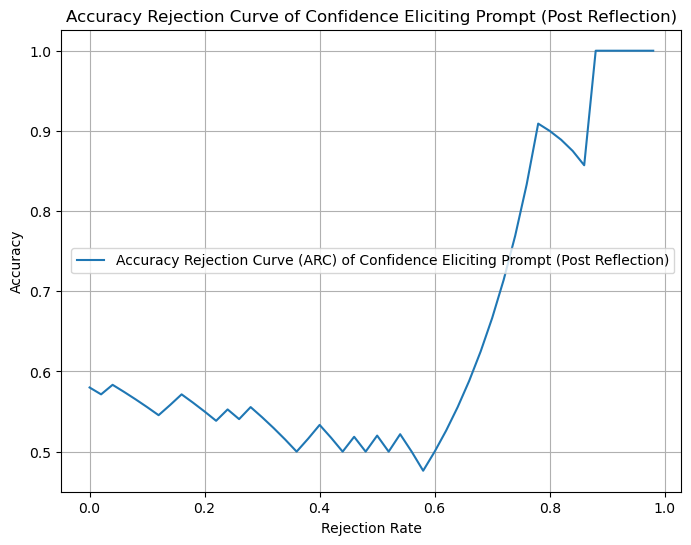

Area Under the Accuracy Rejection Curve (AUARC): 0.6303


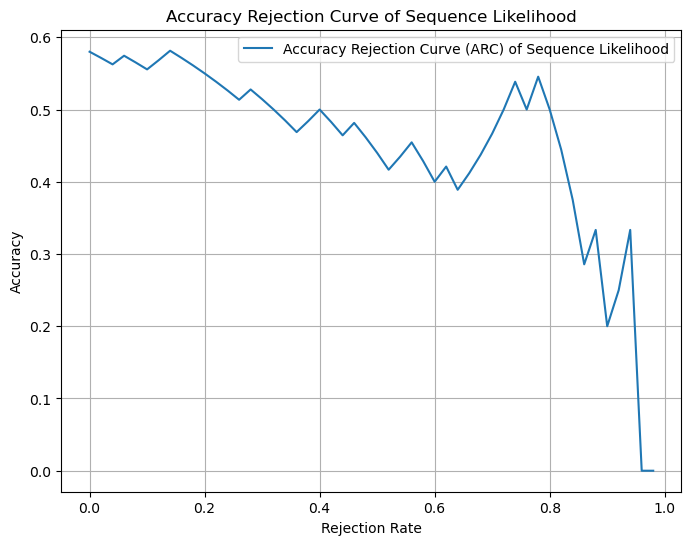

Area Under the Accuracy Rejection Curve (AUARC): 0.4481


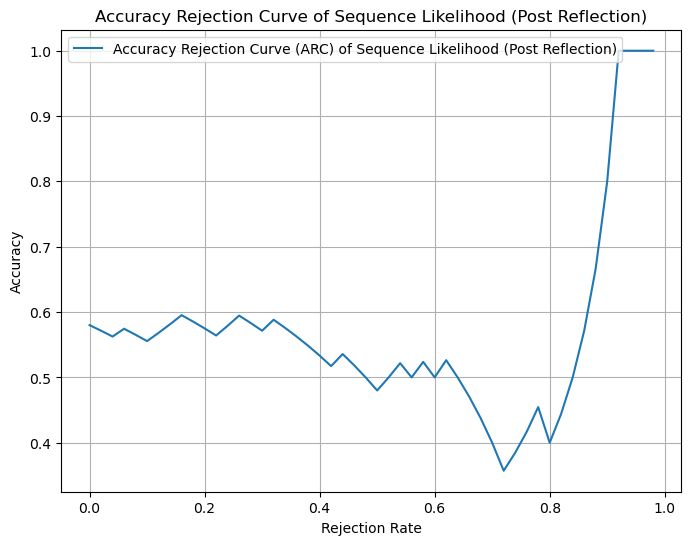

Area Under the Accuracy Rejection Curve (AUARC): 0.5530


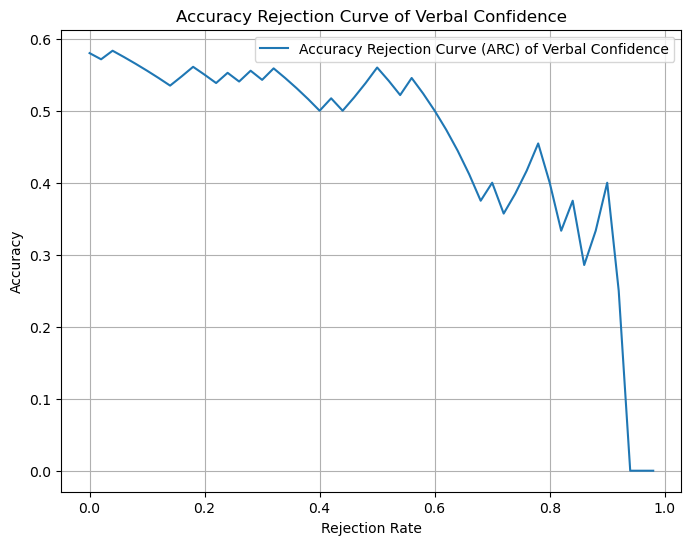

Area Under the Accuracy Rejection Curve (AUARC): 0.4525


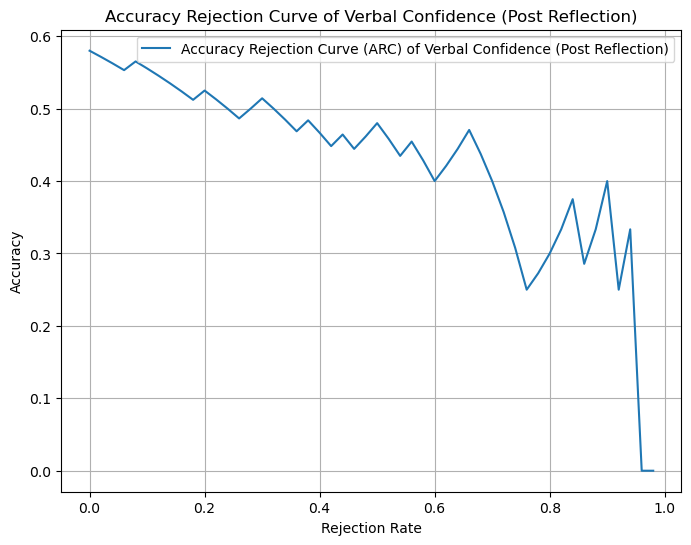

Area Under the Accuracy Rejection Curve (AUARC): 0.4221


0.4220720818944637

In [173]:
plot_arc_and_calculate_auarc(logit_title, logit_predictions)
plot_arc_and_calculate_auarc(logit_post_title, logit_predictions_post)
plot_arc_and_calculate_auarc(sequence_likelihood_title, seq_predictions)
plot_arc_and_calculate_auarc(sequence_likelihood_post_title, seq_predictions_post)
plot_arc_and_calculate_auarc(verbal_confidence_title, ver_predictions)
plot_arc_and_calculate_auarc(verbal_confidence_post_title, ver_predictions_post)

In [177]:
print(compute_accuracy(accuracy))
print(compute_accuracy(accuracy_post_reflection))


print(compute_accuracy(accuracy_post_reflection_seq))

print(compute_accuracy(accuracy_ver))

print(compute_accuracy(accuracy_post_reflection_ver))

0.4
0.6
0.58
0.44
0.56


# Some stats

In [183]:
unanswerable = 0
unanswerable_get_answered = 0
unanswerable_get_answered_post_reflection = 0

for i, d in enumerate(data_list):
    if is_unanswerable(d):
        unanswerable += 1
        if float(d['accuracy']) == 0:
            unanswerable_get_answered += 1
            if (float(d['accuracy_post_reflection']) == 0):
                unanswerable_get_answered_post_reflection += 1
                
print(unanswerable)
print(unanswerable_get_answered)
print(unanswerable_get_answered_post_reflection)

print(unanswerable_get_answered / unanswerable)
print(unanswerable_get_answered_post_reflection / unanswerable)

#     predicted_label = get_predict_label(d, 'accuracy')
#     # p_true
#     accuracy.append(float(d['accuracy']))
#     accuracy_post_reflection.append(float(d['accuracy_post_reflection']))
#     logit_confidence.append(float(d['p_true']))
#     logit_confidence_post.append(float(d['post_reflection_p_true']))
    
#     logit_predictions.append({'true label': true_label, 
#                               'predicted label': predicted_label, 
#                               'confidence': float(d['p_true'])})
#     logit_predictions_post.append({'true label': true_label, 
#                                    'predicted label': get_predict_label(d, 'accuracy_post_reflection'), 
#                                    'confidence': float(d['post_reflection_p_true'])})
    




29
26
18
0.896551724137931
0.6206896551724138


In [184]:
unanswerable = 0
unanswerable_get_answered = 0
unanswerable_get_answered_post_reflection = 0

for i, d in enumerate(data_list):
    if is_unanswerable(d):
        unanswerable += 1
        if float(d['accuracy']) == 0:
            unanswerable_get_answered += 1
            if (float(d['accuracy_post_reflection_seq']) == 0):
                unanswerable_get_answered_post_reflection += 1
                
print(unanswerable)
print(unanswerable_get_answered)
print(unanswerable_get_answered_post_reflection)

print(unanswerable_get_answered / unanswerable)
print(unanswerable_get_answered_post_reflection / unanswerable)

29
26
15
0.896551724137931
0.5172413793103449


In [185]:
unanswerable = 0
unanswerable_get_answered = 0
unanswerable_get_answered_post_reflection = 0

for i, d in enumerate(data_list):
    if is_unanswerable(d):
        unanswerable += 1
        if float(d['accuracy_ver']) == 0:
            unanswerable_get_answered += 1
            if (float(d['accuracy_post_reflection_ver']) == 0):
                unanswerable_get_answered_post_reflection += 1
                
print(unanswerable)
print(unanswerable_get_answered)
print(unanswerable_get_answered_post_reflection)

print(unanswerable_get_answered / unanswerable)
print(unanswerable_get_answered_post_reflection / unanswerable)

29
24
20
0.8275862068965517
0.6896551724137931


In [189]:
count_stubborn = 0
count_overconfidence = 0
for i, d in enumerate(data_list):
    if float(d['accuracy_ver']) == float(d['accuracy_post_reflection_ver']):
        count_stubborn += 1
    if float(d['accuracy_ver']) == 0:        
        if float(d['accuracy_ver']) == float(d['accuracy_post_reflection_ver']):
            count_overconfidence += 1

print(count_stubborn / 50)
print(count_overconfidence / count_stubborn)

0.84
0.5


In [ ]:
count_stubborn = 0
count_overconfidence = 0
for i, d in enumerate(data_list):
    if float(d['accuracy_ver']) == float(d['accuracy_post_reflection_ver']):
        count_stubborn += 1
    if float(d['accuracy_ver']) == 0:        
        if float(d['accuracy_ver']) == float(d['accuracy_post_reflection_ver']):
            count_overconfidence += 1

print(count_stubborn / 50)
print(count_overconfidence / count_stubborn)